#0. Import thư viện

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import xgboost as xgb

from xgboost import plot_tree
from sklearn import tree
from sklearn.tree import export_graphviz
from matplotlib.pylab import rcParams
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, KFold
from sklearn.preprocessing import MinMaxScaler

from sklearn import preprocessing
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, 
    roc_auc_score, roc_curve, auc, average_precision_score, precision_recall_curve,
    ConfusionMatrixDisplay, PrecisionRecallDisplay
)
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, make_scorer, f1_score


from xgboost import XGBClassifier, plot_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

!pip install fast_ml
from fast_ml.feature_selection import get_constant_features
from matplotlib.pyplot import figure

pd.set_option('display.float', '{:.2f}'.format)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 3.3. Chuẩn bị dữ liệu

##3.3.1. Có nên sử dụng toàn bộ dữ liệu gốc?

### 3.3.1.1. Dữ liệu gốc

In [ ]:
data = pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/R Python CK/accepted_2007_to_2018Q4.csv',
    parse_dates=['issue_d'], infer_datetime_format=True)

<ipython-input-30-c7f69341713d>:1: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(


In [ ]:
data.shape

(2260701, 151)

In [ ]:
data['loan_status'].value_counts()

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: loan_status, dtype: int64

Tạo cột issue_yr từ issue_d để lọc ra dữ liệu các năm

<Axes: xlabel='issue_yr', ylabel='count'>

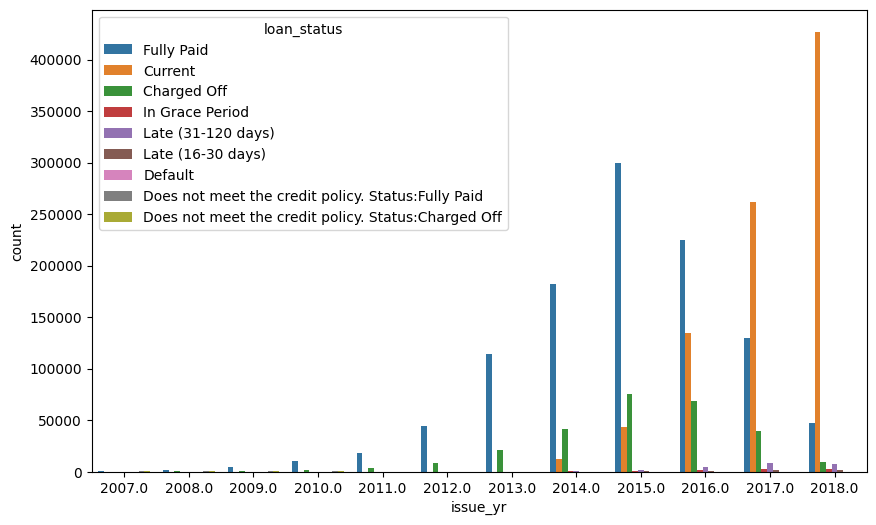

In [ ]:
data.issue_d = pd.to_datetime(data.issue_d)
data['issue_yr'] = data.issue_d.dt.year

plt.figure(figsize=(10,6))
sns.countplot(data=data, x='issue_yr', hue='loan_status')

Ta có thể thấy khối lượng dữ liệu tăng dần theo từng năm. Do tập dữ liệu của chúng ta là rất lớn nên để giảm thời gian xử lý, nhóm sẽ chỉ sử dụng dữ liệu của năm 2015 để thực hiện bài toán. 

Mặc dù theo nguyên tắc, dữ liệu càng gần với hiện tại thì càng có giá trị, tuy nhiên năm 2016, 2017 và 2018 còn khá nhiều đơn vay vẫn chưa hoàn thành, trong khi đó năm 2015 lại có số lượng đơn hoàn thành nhiều nhất. 

Dữ liệu của 2016, 2017 và 2018 vẫn sẽ được nhóm sử dụng để kiểm tra hiệu suất dự đoán của mô hình đã được huấn luyện với tập dữ liệu năm 2015.

Có rất nhiều kết quả mà chúng ta khó đánh giá hoặc sử dụng cho bài toán phân loại, vậy nên ta sẽ chỉ tập trung vào 2 kết quả quan trọng nhất là Fully Paid và Charged Off

In [ ]:
array = ['Charged Off', 'Fully Paid']
data = data.loc[data['loan_status'].isin(array)]
data['loan_status'].value_counts()

Fully Paid     1076751
Charged Off     268559
Name: loan_status, dtype: int64

###3.3.1.2. Dữ liệu theo năm

#### 2018

In [ ]:
data2018 = data[(data.issue_d >= '2018-01-01 00:00:00') & (data.issue_d < '2019-01-01 00:00:00')]
data2018 = data2018.reset_index(drop=True)
data2018.shape

(56311, 152)

In [ ]:
data2018['loan_status'].value_counts()

Fully Paid     47444
Charged Off     8867
Name: loan_status, dtype: int64

In [ ]:
from google.colab import files
data2018.to_csv('lc_2018.csv', encoding = 'utf-8-sig') 
files.download('lc_2018.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### 2017

In [ ]:
data2017 = data[(data.issue_d >= '2017-01-01 00:00:00') & (data.issue_d < '2018-01-01 00:00:00')]
data2017 = data2017.reset_index(drop=True)
data2017.shape

(169300, 152)

In [ ]:
data2017['loan_status'].value_counts()

Fully Paid     130152
Charged Off     39148
Name: loan_status, dtype: int64

In [ ]:
from google.colab import files
data2017.to_csv('lc_2017.csv', encoding = 'utf-8-sig') 
files.download('lc_2017.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### 2016

In [ ]:
data2016 = data[(data.issue_d >= '2016-01-01 00:00:00') & (data.issue_d < '2017-01-01 00:00:00')]
data2016 = data2016.reset_index(drop=True)
data2016.shape

(293095, 152)

In [ ]:
data2016['loan_status'].value_counts()

Fully Paid     224853
Charged Off     68242
Name: loan_status, dtype: int64

In [ ]:
from google.colab import files
data2016.to_csv('lc_2016.csv', encoding = 'utf-8-sig') 
files.download('lc_2016.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### 2015

In [ ]:
data2015 = data[(data.issue_d >= '2015-01-01 00:00:00') & (data.issue_d < '2016-01-01 00:00:00')]
data2015 = data2015.reset_index(drop=True)
data2015.shape

(375545, 152)

In [ ]:
data2015['loan_status'].value_counts()

Fully Paid     299742
Charged Off     75803
Name: loan_status, dtype: int64

In [ ]:
data2015['loan_status'].value_counts()

Fully Paid     299742
Charged Off     75803
Name: loan_status, dtype: int64

In [ ]:
from google.colab import files
data2015.to_csv('lc_2015.csv', encoding = 'utf-8-sig')
files.download('lc_2015.csv')

##3.3.2. Nạp dữ liệu năm 2015

In [14]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/R Python CK/lc_2015.csv')

<ipython-input-14-ea612b938f2b>:1: DtypeWarning: Columns (20,60) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/R Python CK/lc_2015.csv')


Lúc tạo tập dữ liệu 2015 này, có 2 cột mới được thêm vào là index mới của từng dòng (có giá trị độc nhất) và năm phát hành khoản vay (issue_yr) được trích từ cột tháng phát hành khoản vay (issue_d) mà nhóm dùng để lọc dữ liệu các năm.

Vậy nên, nhóm sẽ loại bỏ 2 cột này trước

In [15]:
data.drop(data.columns[[0]], axis=1, inplace=True)
data.drop(columns=['issue_yr'], axis=1, inplace=True)

In [16]:
data.shape

(375545, 151)

Tập dữ liệu có 375 545 dòng và 151 cột

## 3.3.3 Mô tả dữ liệu

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375545 entries, 0 to 375544
Columns: 151 entries, id to settlement_term
dtypes: float64(115), int64(1), object(35)
memory usage: 432.6+ MB


In [ ]:
data.describe()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,...,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,deferral_term,hardship_amount,hardship_length,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,settlement_amount,settlement_percentage,settlement_term
count,375545.00,0.00,375545.00,375545.00,375545.00,375545.00,375545.00,375545.00,375543.00,375545.00,375545.00,375545.00,375545.00,194197.00,68444.00,375545.00,375545.00,375545.00,375391.00,375545.00,375545.00,375545.00,375545.00,375545.00,375545.00,...,375545.00,375545.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1869.00,1869.00,1869.00,1869.00,1420.00,1869.00,1869.00,11438.00,11438.00,11438.00
mean,53815997.69,NaN,14641.56,14641.56,14635.76,12.39,437.82,76269.21,18.94,0.35,693.52,697.52,0.59,34.19,66.64,11.88,0.24,17117.77,53.11,25.43,0.00,0.00,15188.47,15182.64,12461.62,...,21551.05,42705.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.00,104.54,3.00,14.20,296.01,8352.00,163.21,4869.66,47.20,12.77
std,9492665.00,NaN,8522.70,8522.70,8519.39,4.32,251.33,74990.89,8.89,0.93,30.34,30.34,0.88,22.02,25.51,5.61,0.66,23881.97,23.90,12.14,0.00,0.00,10080.96,10077.21,8710.15,...,21726.46,43439.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,95.48,0.00,9.84,274.08,6085.44,176.59,3523.41,6.23,7.82
min,56705.00,NaN,1000.00,1000.00,900.00,5.32,14.01,0.00,0.00,0.00,660.00,664.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,4.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.00,0.64,3.00,0.00,1.92,55.73,0.02,107.00,0.45,0.00
25%,45724591.00,NaN,8000.00,8000.00,8000.00,9.17,255.04,45000.00,12.39,0.00,670.00,674.00,0.00,15.00,50.00,8.00,0.00,6208.00,35.30,17.00,0.00,0.00,7343.05,7341.00,5600.00,...,7600.00,15002.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.00,33.71,3.00,6.00,96.95,3471.33,34.76,2117.18,45.00,6.00
50%,55260445.00,NaN,12550.00,12550.00,12525.00,12.29,377.04,65000.00,18.38,0.00,685.00,689.00,0.00,31.00,67.00,11.00,0.00,11495.00,53.30,24.00,0.00,0.00,12682.10,12676.36,10000.00,...,14800.00,32331.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.00,70.26,3.00,15.00,192.99,6753.42,95.07,4168.86,45.00,12.00
75%,61652593.00,NaN,20000.00,20000.00,20000.00,14.99,578.68,90000.00,25.10,0.00,710.00,714.00,1.00,51.00,82.00,15.00,0.00,20579.00,71.40,32.00,0.00,0.00,21055.10,21048.32,18000.00,...,27900.00,57286.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.00,149.78,3.00,23.00,431.19,12154.19,241.29,6729.75,50.00,18.00
max,68617057.00,NaN,35000.00,35000.00,35000.00,28.99,1445.46,9500000.00,999.00,39.00,845.00,850.00,6.00,176.00,120.00,90.00,86.00,2904836.00,193.00,169.00,0.00,0.00,61184.57,61184.57,35000.00,...,684000.00,2101913.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.00,638.13,3.00,30.00,1914.39,29401.04,1247.48,30000.00,166.67,112.00


In [ ]:
data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,...,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.00,3600.00,3600.00,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.00,Not Verified,2015-12-01,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.91,...,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.00,24700.00,24700.00,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.00,Not Verified,2015-12-01,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,Business,577xx,SD,16.06,...,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.00,20000.00,20000.00,60 months,10.78,432.66,B,B4,truck driver,10+ years,MORTGAGE,63000.00,Not Verified,2015-12-01,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,home_improvement,NaN,605xx,IL,10.78,...,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,68476807,NaN,10400.00,10400.00,10400.00,60 months,22.45,289.91,F,F1,Contract Specialist,3 years,MORTGAGE,104433.00,Source Verified,2015-12-01,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,major_purchase,Major purchase,174xx,PA,25.37,...,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68426831,NaN,11950.00,11950.00,11950.00,36 months,13.44,405.18,C,C3,Veterinary Tecnician,4 years,RENT,34000.00,Source Verified,2015-12-01,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,300xx,GA,10.20,...,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


# 3.4. Khai phá dữ liệu và tiền xử lý dữ liệu

Tập dữ liệu gốc có đến 151 thuộc tính, do không thể đi sâu vào phân tích hết toàn bộ các biến, nhóm sẽ vừa xử lý và khai phá dữ liệu cùng lúc

##3.4.1. Biến mục tiêu

In [ ]:
data['loan_status'].value_counts()

Fully Paid     299742
Charged Off     75803
Name: loan_status, dtype: int64

<Axes: ylabel='loan_status'>

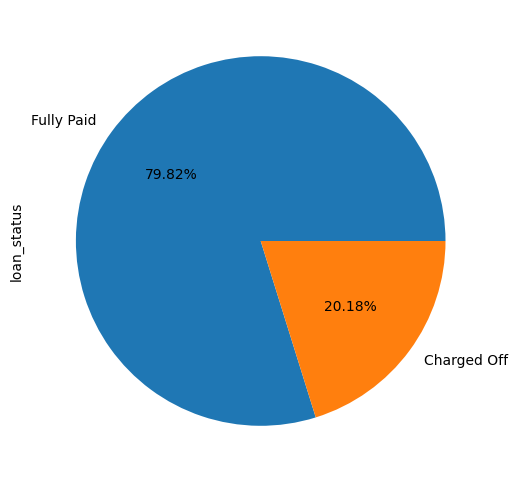

In [ ]:
plt.figure(figsize=(10,6))
data['loan_status'].value_counts(sort=False).plot.pie(autopct='%.2f%%')

## 3.4.2. Loại bỏ các biến không cần thiết

###3.4.2.1. Các biến thiếu nhiều dữ liệu

Text(0, 0.5, 'Feature count')

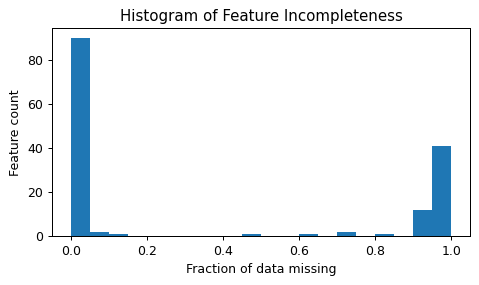

In [17]:
missing_fractions = data.isnull().mean().sort_values(ascending=False)
plt.figure(figsize=(6,3), dpi=90)
missing_fractions.plot.hist(bins=20)
plt.title('Histogram of Feature Incompleteness')
plt.xlabel('Fraction of data missing')
plt.ylabel('Feature count')

Có sự chênh lệch rõ rệt về lượng dữ liệu bị thiếu giữa các cột, chúng ta sẽ loại bỏ các cột thiếu nhiều hơn 40% dữ liệu

In [18]:
drop_list = sorted(list(missing_fractions[missing_fractions > 0.4].index))
len(drop_list)

58

In [19]:
data.drop(labels=drop_list, axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375545 entries, 0 to 375544
Data columns (total 93 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          375545 non-null  int64  
 1   loan_amnt                   375545 non-null  float64
 2   funded_amnt                 375545 non-null  float64
 3   funded_amnt_inv             375545 non-null  float64
 4   term                        375545 non-null  object 
 5   int_rate                    375545 non-null  float64
 6   installment                 375545 non-null  float64
 7   grade                       375545 non-null  object 
 8   sub_grade                   375545 non-null  object 
 9   emp_title                   353442 non-null  object 
 10  emp_length                  353487 non-null  object 
 11  home_ownership              375545 non-null  object 
 12  annual_inc                  375545 non-null  float64
 13  verification_s

###3.4.2.2. Các biến chỉ có giá trị giống nhau hoặc phần lớn giá trị giống nhau

In [20]:
#Giá trị giống nhau
constant_features = get_constant_features(data, threshold=0.9)
constant_features

,Desc,Var,Value,Perc
0,Constant,pymnt_plan,n,100.00
1,Constant,out_prncp_inv,0.00,100.00
2,Constant,disbursement_method,Cash,100.00
3,Constant,hardship_flag,N,100.00
4,Constant,policy_code,1.00,100.00
5,Constant,out_prncp,0.00,100.00
6,Quasi Constant,application_type,Individual,99.89
7,Quasi Constant,num_tl_30dpd,0.00,99.63
8,Quasi Constant,delinq_amnt,0.00,99.57
9,Quasi Constant,acc_now_delinq,0.00,99.44


In [21]:
constant_features_list = constant_features['Var'].to_list()
data.drop(columns=constant_features_list, axis=1, inplace=True)

###3.4.2.3. Các biến có nhiều giá trị khác nhau

In [22]:
#Giá trị khác nhau
for col in data.select_dtypes(include=['int64', 'object']):
    count = data[col].nunique()
    print('Count of Unique values in Column ', col, ' is : ', count)

Count of Unique values in Column  id  is :  375545
Count of Unique values in Column  term  is :  2
Count of Unique values in Column  grade  is :  7
Count of Unique values in Column  sub_grade  is :  35
Count of Unique values in Column  emp_title  is :  109810
Count of Unique values in Column  emp_length  is :  11
Count of Unique values in Column  home_ownership  is :  4
Count of Unique values in Column  verification_status  is :  3
Count of Unique values in Column  issue_d  is :  12
Count of Unique values in Column  loan_status  is :  2
Count of Unique values in Column  url  is :  375545
Count of Unique values in Column  purpose  is :  14
Count of Unique values in Column  title  is :  25
Count of Unique values in Column  zip_code  is :  910
Count of Unique values in Column  addr_state  is :  49
Count of Unique values in Column  earliest_cr_line  is :  665
Count of Unique values in Column  initial_list_status  is :  2
Count of Unique values in Column  last_pymnt_d  is :  51
Count of Uni

In [23]:
data.id.nunique()

375545

Ta sẽ loại bỏ các biến chỉ có giá trị khác nhau hoặc có quá nhiều giá trị khác nhau như id, url, zip_code. Ta sẽ giữ lại cột emp_title để phân tích rồi loại bỏ sau.

In [24]:
data.drop(columns=['id', 'url', 'zip_code'], axis=1, inplace=True)

###3.4.2.4. Các biến chỉ xuất hiện sau khi khoản vay được phát hành

Một số cột thuộc tính chỉ có sau khi xuất hiện khoản vay cũng nên được loại bỏ, nhưng ta hãy thử xem trước một số thuộc tính

In [25]:
funded_paid_df = data[['funded_amnt', 'total_pymnt', 'loan_status']].copy()

In [26]:
funded_paid_df['percentage_paid'] = funded_paid_df['total_pymnt']/funded_paid_df['funded_amnt']

In [27]:
funded_paid_df 

,funded_amnt,total_pymnt,loan_status,percentage_paid
0,3600.00,4421.72,Fully Paid,1.23
1,24700.00,25679.66,Fully Paid,1.04
2,20000.00,22705.92,Fully Paid,1.14
3,10400.00,11740.50,Fully Paid,1.13
4,11950.00,13708.95,Fully Paid,1.15
...,...,...,...,...
375540,10000.00,11947.24,Fully Paid,1.19
375541,24000.00,28663.69,Fully Paid,1.19
375542,13000.00,6109.52,Charged Off,0.47
375543,12000.00,5366.99,Charged Off,0.45


In [28]:
array = ['Charged Off']
funded_paid_co_df = funded_paid_df.loc[funded_paid_df['loan_status'].isin(array)]

In [29]:
#percentage loss
1 - funded_paid_co_df['total_pymnt'].sum()/funded_paid_co_df['funded_amnt'].sum()

0.4209506640790096

In [30]:
array = ['Fully Paid']
funded_paid_fp_df = funded_paid_df.loc[funded_paid_df['loan_status'].isin(array)]

In [31]:
#percentage gain
funded_paid_fp_df ['total_pymnt'].sum()/funded_paid_fp_df ['funded_amnt'].sum() - 1

0.16421848553881513

In [32]:
funded_paid_df.loc[funded_paid_df['percentage_paid'] >=1, 'loan_status'].value_counts()

Fully Paid     299742
Charged Off      5752
Name: loan_status, dtype: int64

In [33]:
funded_paid_df.loc[funded_paid_df['percentage_paid'] <1, 'loan_status'].value_counts()

Charged Off    70051
Name: loan_status, dtype: int64

In [34]:
after_loan_columns = ['issue_d', 'funded_amnt', 'funded_amnt_inv', 'total_pymnt', 'total_pymnt_inv', 'recoveries', 'collection_recovery_fee',
                      'total_rec_int', 'total_rec_prncp', 'last_pymnt_d', 'last_pymnt_amnt',  'last_credit_pull_d']
data.drop(columns=after_loan_columns, axis=1, inplace=True)

##3.4.3. Các biến định lượng

array([[<Axes: title={'center': 'loan_amnt'}>,
        <Axes: title={'center': 'int_rate'}>,
        <Axes: title={'center': 'installment'}>,
        <Axes: title={'center': 'annual_inc'}>,
        <Axes: title={'center': 'dti'}>,
        <Axes: title={'center': 'delinq_2yrs'}>,
        <Axes: title={'center': 'fico_range_low'}>],
       [<Axes: title={'center': 'fico_range_high'}>,
        <Axes: title={'center': 'inq_last_6mths'}>,
        <Axes: title={'center': 'open_acc'}>,
        <Axes: title={'center': 'pub_rec'}>,
        <Axes: title={'center': 'revol_bal'}>,
        <Axes: title={'center': 'revol_util'}>,
        <Axes: title={'center': 'total_acc'}>],
       [<Axes: title={'center': 'last_fico_range_high'}>,
        <Axes: title={'center': 'last_fico_range_low'}>,
        <Axes: title={'center': 'tot_coll_amt'}>,
        <Axes: title={'center': 'tot_cur_bal'}>,
        <Axes: title={'center': 'total_rev_hi_lim'}>,
        <Axes: title={'center': 'acc_open_past_24mths'}>,
  

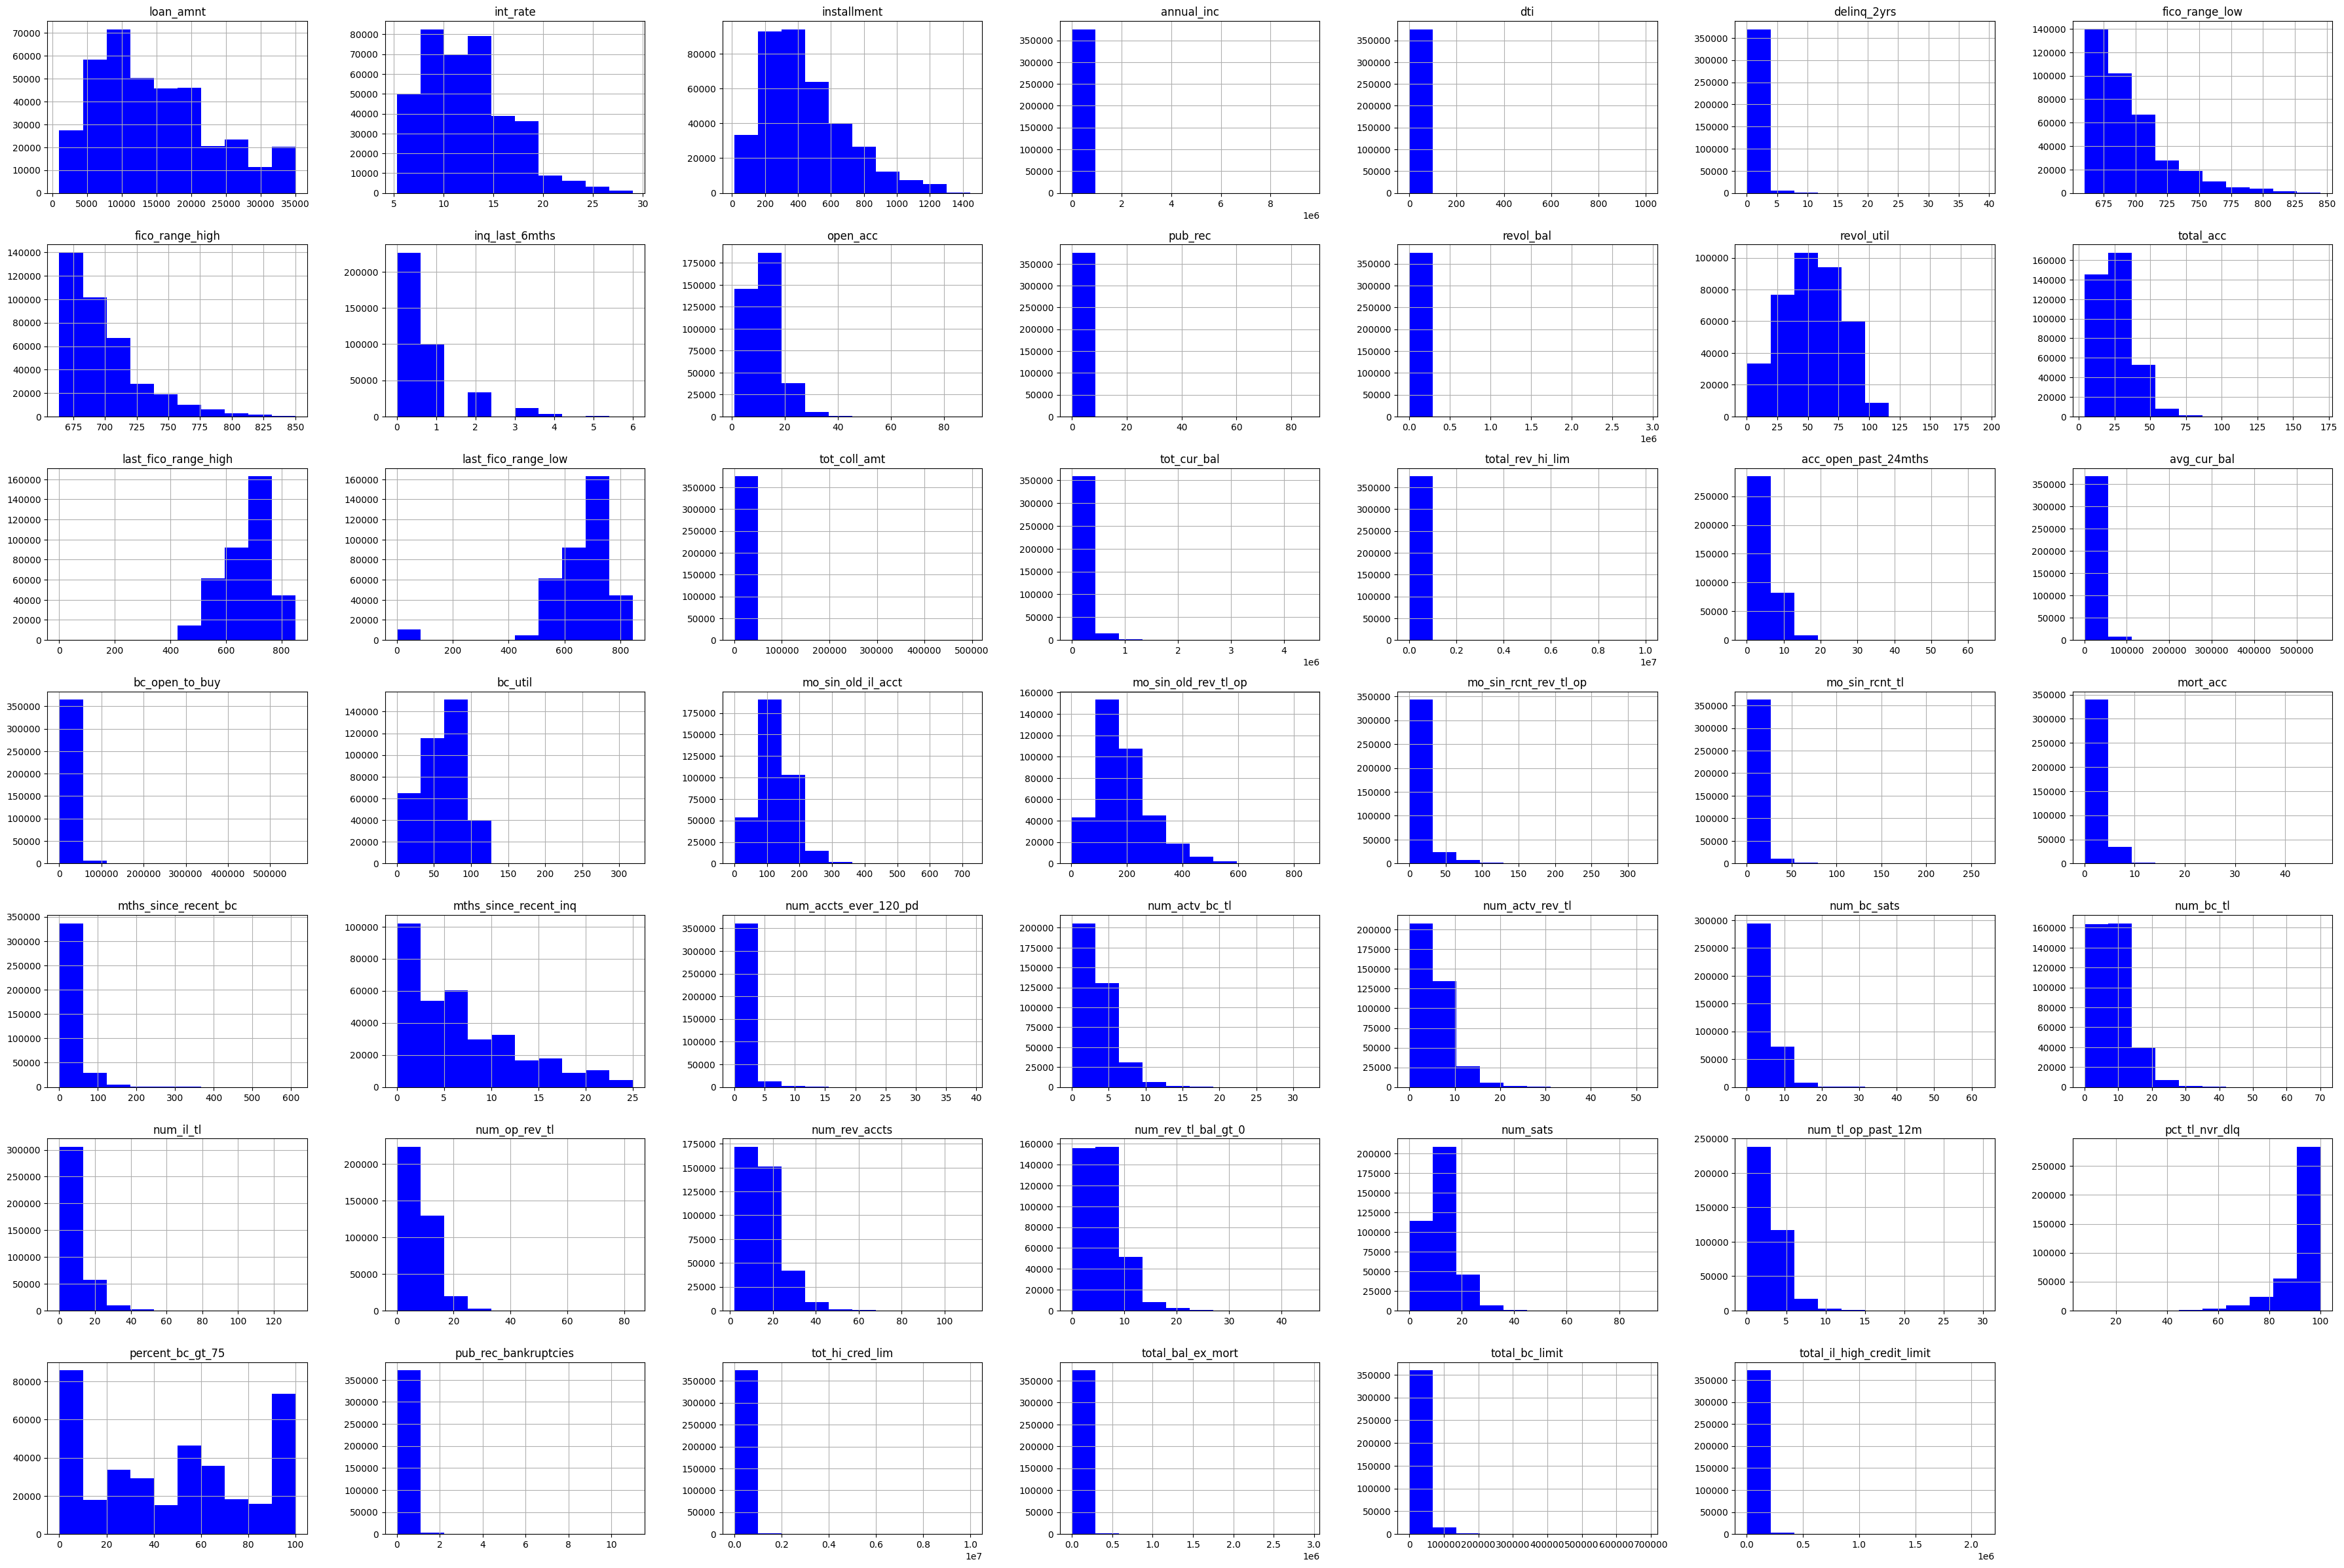

In [ ]:
data.hist(bins = 10, figsize = (45,30), color = 'b')

In [ ]:
data['loan_amnt'].mean()

14641.563993662543

In [ ]:
data['annual_inc'].mean()

76269.21320579425

In [ ]:
tg = data['loan_amnt'] * data['int_rate']

In [ ]:
#interest rate
tg.sum()/data['loan_amnt'].sum()

12.699375245535602

In [ ]:
data[data['annual_inc']>55775]['annual_inc'].count()

227649

##3.4.4. Các biến định tính

In [35]:
print([column for column in data.columns if data[column].dtype == object])

['term', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'verification_status', 'loan_status', 'purpose', 'title', 'addr_state', 'earliest_cr_line', 'initial_list_status']


###3.4.4.1. emp_length & emp_title

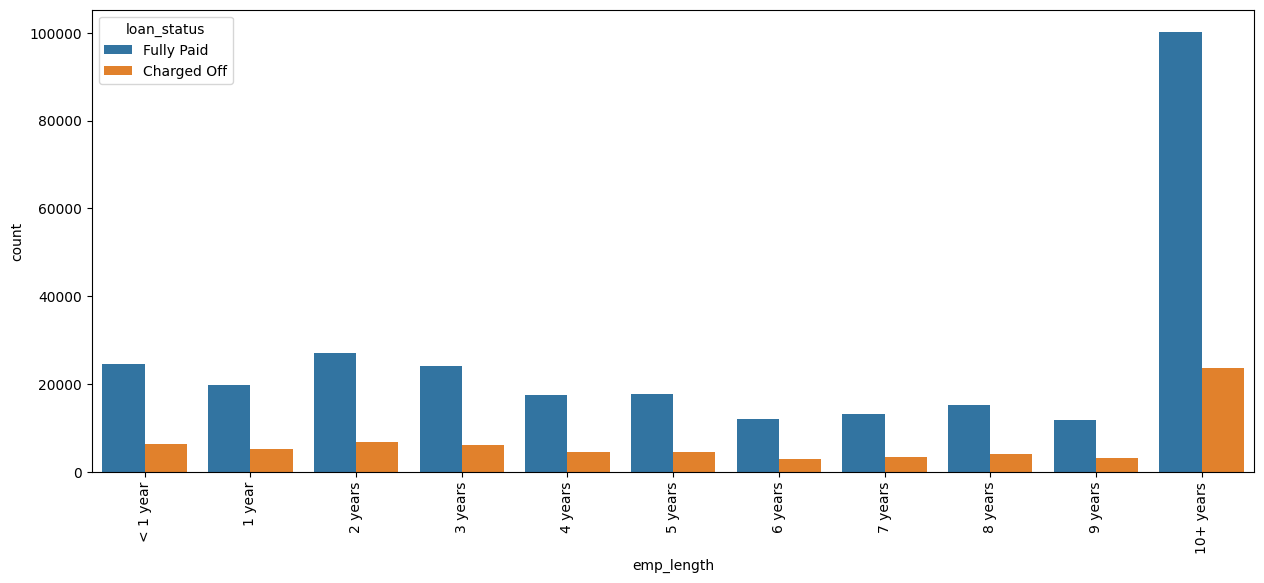

In [36]:
plt.figure(figsize=(15, 6))

order = ['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', 
          '6 years', '7 years', '8 years', '9 years', '10+ years',]
g = sns.countplot(x='emp_length', data=data, hue='loan_status', order=order)
g.set_xticklabels(g.get_xticklabels(), rotation=90);

In [37]:
# Thay đổi một số giá trị trong cột emp_length và chuyển về kiểu float
data['emp_length'] = data['emp_length'].replace({'< 1 year': '0 years', '10+ years': '11 years'})
data['emp_length'] = data['emp_length'].str.extract('(\d+)').astype('float')

Text(0.5, 1.0, 'Top 30 job titles that can afford a loan')

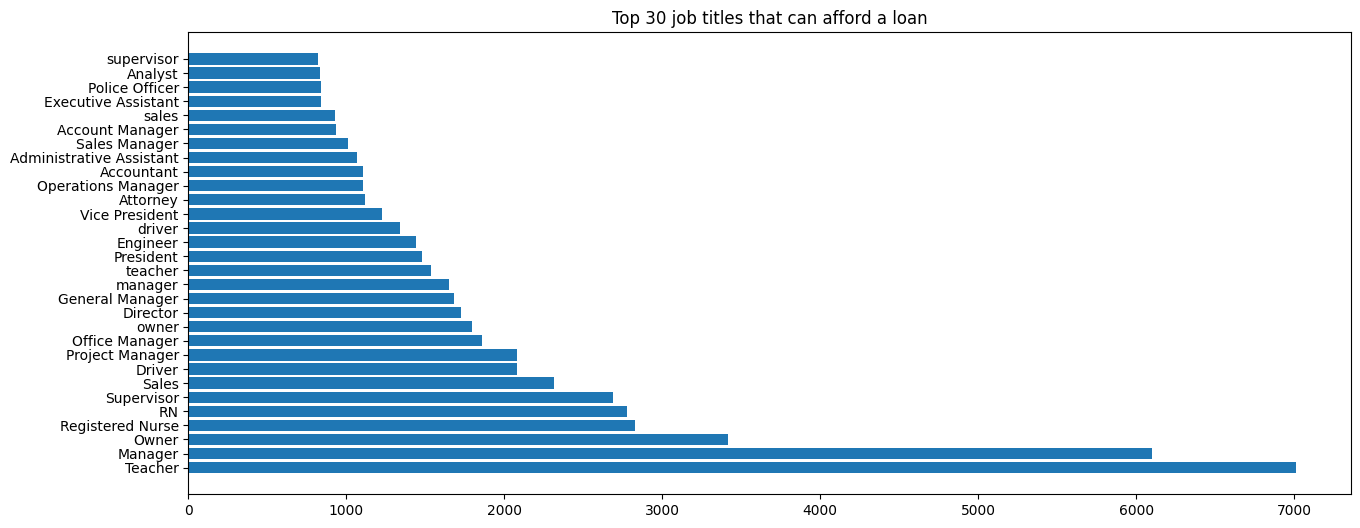

In [38]:
plt.figure(figsize=(15, 6))
plt.barh(data.emp_title.value_counts()[:30].index, data.emp_title.value_counts()[:30])
plt.title("Top 30 job titles that can afford a loan")

In [39]:
data.drop(columns=['emp_title'], axis=1, inplace=True)

###3.4.4.2. earliest_cr_line

In [40]:
# Chuyển earliest_cr_line về kiểu datetime sau đó chuyển về kiểu numeric bằng cách chỉ lấy giá trị năm
data['earliest_cr_line'] = pd.to_datetime(data['earliest_cr_line'])
data['earliest_cr_line'] = data.earliest_cr_line.dt.year

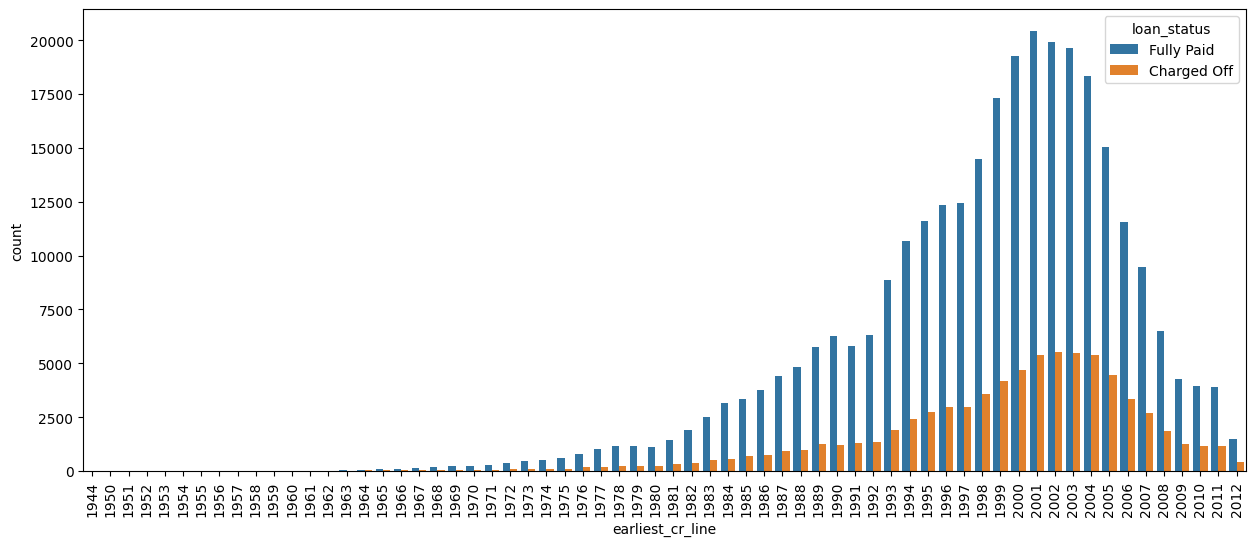

In [41]:
plt.figure(figsize=(15,6))
earliest_cr_line = sorted(data.earliest_cr_line.unique().tolist())
g = sns.countplot(x='earliest_cr_line', data=data, hue='loan_status', order=earliest_cr_line)
g.set_xticklabels(g.get_xticklabels(), rotation=90);

###3.4.4.3. grade & sub_grade

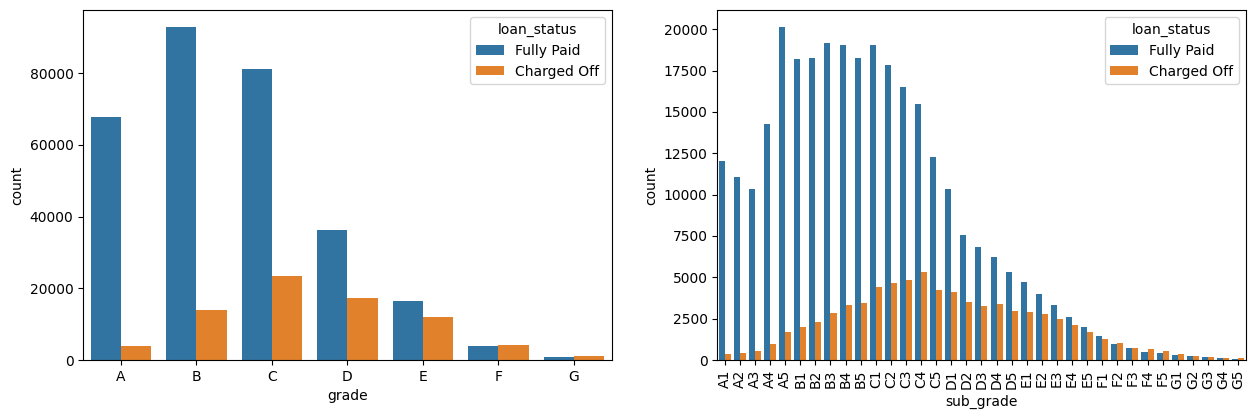

In [42]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
grade = sorted(data.grade.unique().tolist())
sns.countplot(x='grade', data=data, hue='loan_status', order=grade)

plt.subplot(2, 2, 2)
sub_grade = sorted(data.sub_grade.unique().tolist())
g = sns.countplot(x='sub_grade', data=data, hue='loan_status', order=sub_grade)
g.set_xticklabels(g.get_xticklabels(), rotation=90);

Text(0, 0.5, 'Average Interest Rate')

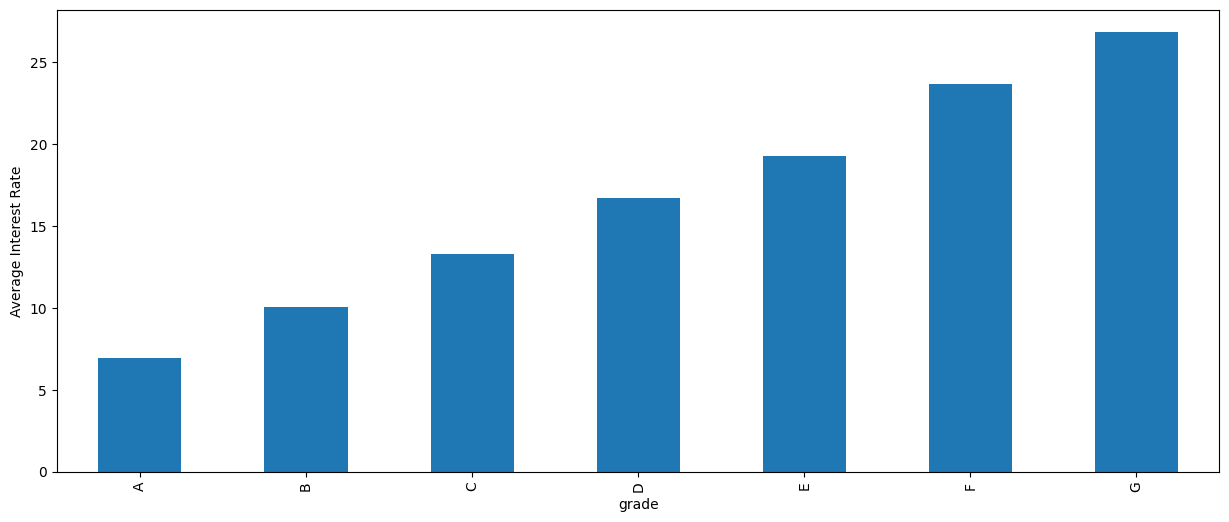

In [43]:
means_grade = data.groupby(["grade"]).mean()['int_rate']
ax = means_grade.plot(kind = 'bar', figsize=(15,6))
ax.set_ylabel('Average Interest Rate')

Dễ thấy lý do vì sao các khoản vay hạng F và G lại có số lượng ít như vậy. Đây chính là những khoản vay rủi ro cao

grade chỉ là phân hạng tổng quát từ sub_grade nên ta cũng sẽ loại bỏ nó




In [44]:
data.drop('grade', axis=1, inplace=True)

###3.4.4.4. purpose & title

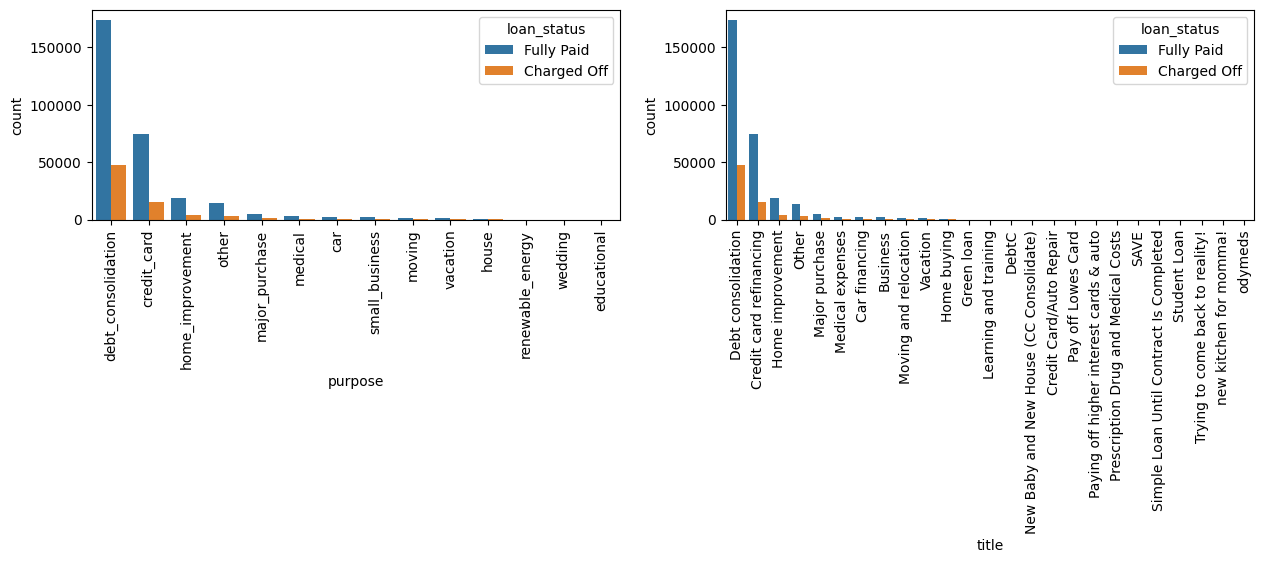

In [45]:
purposedf = data[['purpose']].groupby(['purpose'])['purpose'] \
                                      .count() \
                                      .reset_index(name='count') \
                                      .sort_values(['count'], ascending=False)
purpose = purposedf.purpose.values

titledf = data[['title']].groupby(['title'])['title'] \
                                      .count() \
                                      .reset_index(name='count') \
                                      .sort_values(['count'], ascending=False)
title = titledf.title.values

plt.figure(figsize=(15, 6))

plt.subplot(2, 2, 1)
p = sns.countplot(x='purpose', data=data, hue='loan_status', order=purpose)
p.set_xticklabels(p.get_xticklabels(), rotation=90);

plt.subplot(2, 2, 2)
t = sns.countplot(x='title', data=data, hue='loan_status', order=title)
t.set_xticklabels(t.get_xticklabels(), rotation=90);

Text(0, 0.5, 'Average Loan Amount')

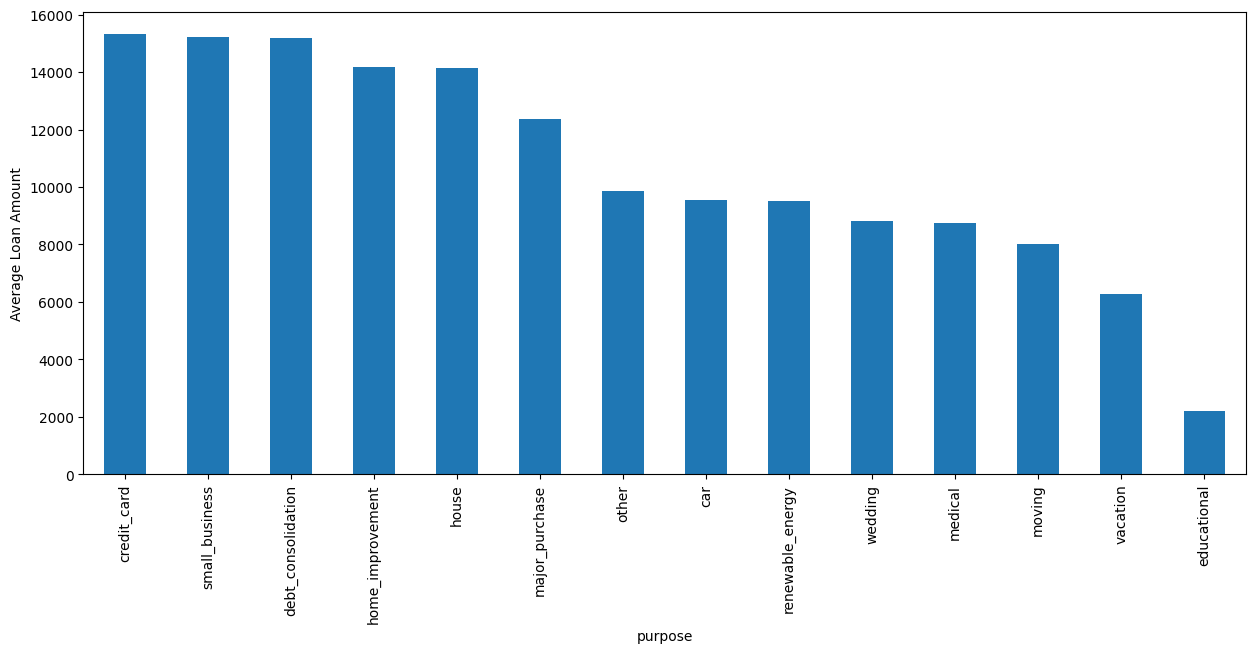

In [46]:
means_purpose = data.groupby(["purpose"]).mean()['loan_amnt'].sort_values(ascending=False)
ax = means_purpose.plot(kind = 'bar', figsize=(15,6))
ax.set_ylabel('Average Loan Amount')

Cột title cũng chỉ là mô tả cho cột purpose, vì thế ta cũng sẽ loại bỏ cột này

In [47]:
data.drop('title', axis=1, inplace=True)

###3.4.4.5. Các biến định tính khác

<Axes: xlabel='home_ownership', ylabel='Average Interest Rate'>

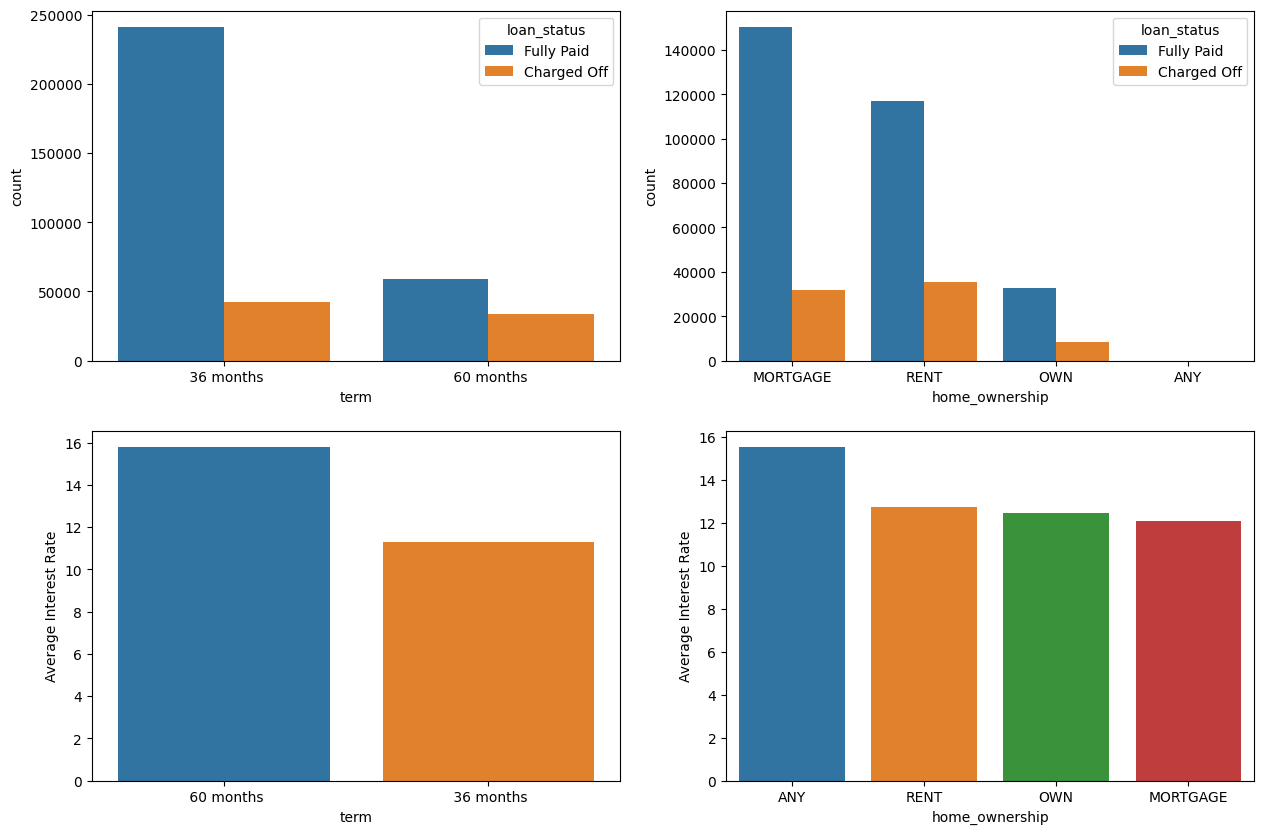

In [48]:
fig, ax = plt.subplots(nrows=2 , ncols=2, figsize=(15,10))

sns.countplot(x='term', data=data, hue='loan_status', ax=ax[0,0])
sns.countplot(x='home_ownership', data=data, hue='loan_status', ax=ax[0,1])

means_term = data.groupby(["term"]).mean()['int_rate'].reset_index(name="Average Interest Rate").sort_values(by='Average Interest Rate', ascending=False)
sns.barplot(data=means_term, x="term", y="Average Interest Rate", ax=ax[1,0])

means_home_ownership = data.groupby(["home_ownership"]).mean()['int_rate'].reset_index(name="Average Interest Rate").sort_values(by='Average Interest Rate', ascending=False)
sns.barplot(data=means_home_ownership, x="home_ownership", y="Average Interest Rate", ax=ax[1,1])

<Axes: xlabel='initial_list_status', ylabel='Average Interest Rate'>

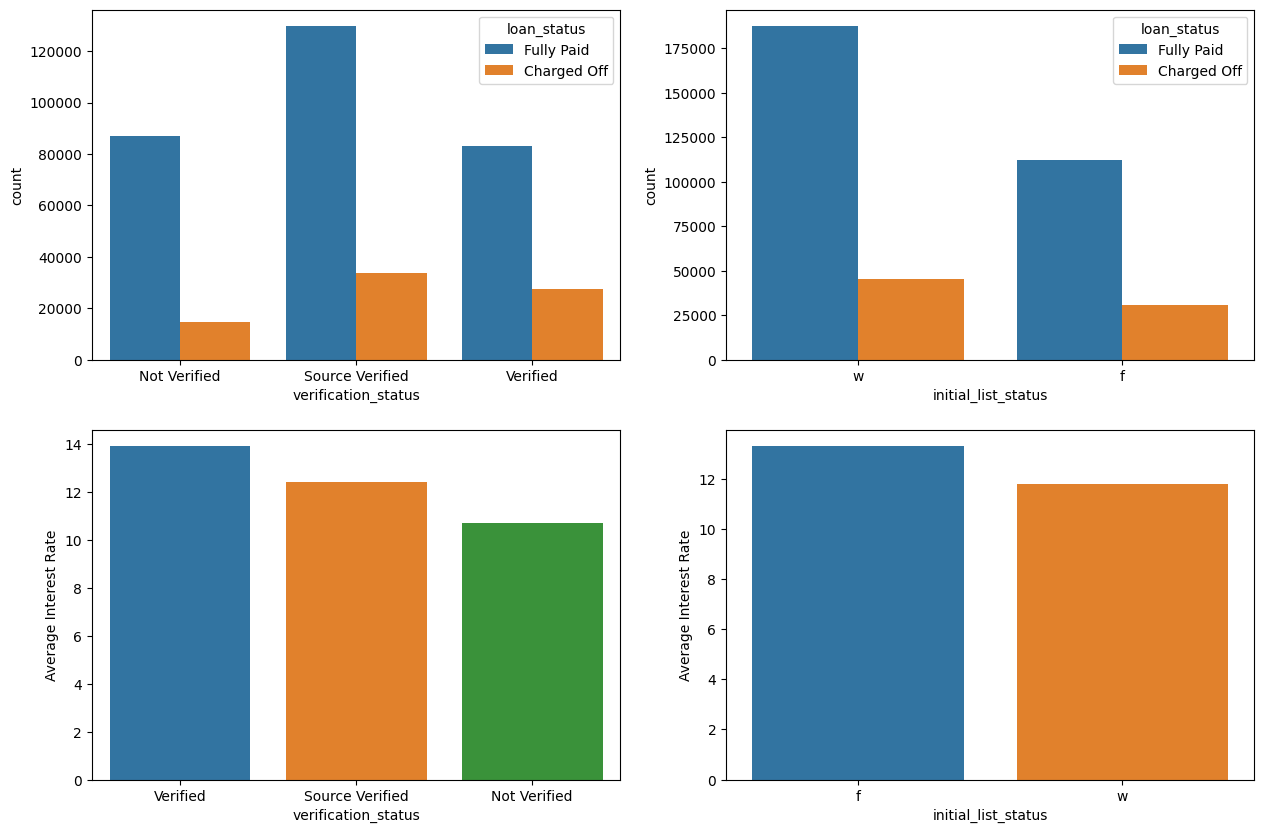

In [49]:
fig, ax = plt.subplots(nrows=2 , ncols=2, figsize=(15,10))

sns.countplot(x='verification_status', data=data, hue='loan_status', ax=ax[0,0])
sns.countplot(x='initial_list_status', data=data, hue='loan_status', ax=ax[0,1])

means_verification_status = data.groupby(["verification_status"]).mean()['int_rate'].reset_index(name="Average Interest Rate").sort_values(by='Average Interest Rate', ascending=False)
sns.barplot(data=means_verification_status, x="verification_status", y="Average Interest Rate", ax=ax[1,0])

means_initial_list_status = data.groupby(["initial_list_status"]).mean()['int_rate'].reset_index(name="Average Interest Rate").sort_values(by='Average Interest Rate', ascending=False)
sns.barplot(data=means_initial_list_status, x="initial_list_status", y="Average Interest Rate", ax=ax[1,1])

Chuyển term về kiểu định lượng

In [50]:
term_values = {' 36 months': 36, ' 60 months': 60}
data['term'] = data.term.map(term_values)

##3.4.5. Loại bỏ giá trị ngoại lai

In [51]:
data.shape

(375545, 58)

In [52]:
data = data[data['annual_inc'] <= 200000]
data = data[data['dti'] <= 50]
data = data[data['delinq_2yrs'] <= 10]

data = data[data['open_acc'] <= 40]
data = data[data['pub_rec'] <= 10]
data = data[data['revol_bal'] <= 250000]
data = data[data['revol_util'] <= 125]

data = data[data['total_acc'] <= 80]
data = data[data['tot_coll_amt'] <= 200000]
data = data[data['tot_cur_bal'] <= 1500000]

data = data[data['total_rev_hi_lim'] <= 200000]
data = data[data['acc_open_past_24mths'] <= 30]
data = data[data['avg_cur_bal'] <= 200000]
data = data[data['bc_open_to_buy'] <= 200000]
data = data[data['bc_util'] <= 150]
data = data[data['mo_sin_old_il_acct'] <= 400]
data = data[data['mo_sin_old_rev_tl_op'] <= 700]

data = data[data['mo_sin_rcnt_rev_tl_op'] <= 150]
data = data[data['mo_sin_rcnt_tl'] <= 100]
data = data[data['mort_acc'] <= 10]
data = data[data['mths_since_recent_bc'] <= 250]
data = data[data['num_accts_ever_120_pd'] <= 15]
data = data[data['num_actv_bc_tl'] <= 15]

data = data[data['num_sats'] <= 50]
data = data[data['num_tl_op_past_12m'] <= 15]
data = data[data['pct_tl_nvr_dlq'] >= 50]
data = data[data['pub_rec_bankruptcies'] <= 4]
data = data[data['tot_hi_cred_lim'] <= 2000000]
data = data[data['total_bal_ex_mort'] <= 600000]

data = data[data['total_bc_limit'] <= 200000]
data = data[data['total_il_high_credit_limit'] <= 500000]

In [53]:
data.shape

(347533, 58)

#3.5. Feature Selection

##3.5.1. Pre-training mô hình XGBoost

In [54]:
data['loan_status'] = data.loan_status.map({'Fully Paid':1, 'Charged Off':0})
def print_score(true, pred, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")

###3.5.7.1. Với Get Dummies

In [55]:
dm = data.copy()

dmcols = list(dm.select_dtypes(include=['object']).columns.values)
dm = pd.get_dummies(dm, columns=dmcols, drop_first=True)
dm.shape

(347533, 152)

In [56]:
train0, test0 = train_test_split(dm, test_size=0.2, random_state=42)

X_train0, y_train0 = train0.drop('loan_status', axis=1), train0.loan_status
X_test0, y_test0 = test0.drop('loan_status', axis=1), test0.loan_status

X_train0 = np.array(X_train0).astype(np.float32)
X_test0 = np.array(X_test0).astype(np.float32)
y_train0 = np.array(y_train0).astype(np.float32)
y_test0 = np.array(y_test0).astype(np.float32)

In [73]:
xgb_clf = XGBClassifier(tree_method="hist", enable_categorical=True, random_state=42)

start = time.time()
xgb_clf.fit(X_train0, y_train0)
end = time.time()
dummiesTime = end - start

In [66]:
y_train_pred0 = xgb_clf.predict(X_train0)
print_score(y_train0, y_train_pred0, train=True)

y_test_pred0 = xgb_clf.predict(X_test0)
print_score(y_test0, y_test_pred0, train=False)

print('Elapsed Time: ', dummiesTime)

Train Result:
Accuracy Score: 92.34%
_______________________________________________
CLASSIFICATION REPORT:
               0.0       1.0  accuracy  macro avg  weighted avg
precision     0.81      0.95      0.92       0.88          0.92
recall        0.81      0.95      0.92       0.88          0.92
f1-score      0.81      0.95      0.92       0.88          0.92
support   56801.00 221225.00      0.92  278026.00     278026.00
_______________________________________________
Confusion Matrix: 
 [[ 46283  10518]
 [ 10788 210437]]

Test Result:
Accuracy Score: 90.89%
_______________________________________________
CLASSIFICATION REPORT:
               0.0      1.0  accuracy  macro avg  weighted avg
precision     0.77     0.94      0.91       0.86          0.91
recall        0.78     0.94      0.91       0.86          0.91
f1-score      0.77     0.94      0.91       0.86          0.91
support   14018.00 55489.00      0.91   69507.00      69507.00
______________________________________________

###3.5.7.2. Với Label Encoding

In [ ]:
from sklearn import preprocessing
for (columnName, columnData) in data.iteritems():
    if(columnData.dtype != 'float64'):
        if columnData.dtype == 'object':
            le = preprocessing.LabelEncoder()
            le.fit(columnData.values.astype(str))
            data[columnName] = le.transform(columnData.values.astype(str))
        else:
            le = preprocessing.LabelEncoder()
            le.fit(columnData.values)
            data[columnName] = le.transform(columnData.values)

In [ ]:
data.shape

(347533, 58)

In [ ]:
train, test = train_test_split(data, test_size=0.2, random_state=42)

X_train, y_train = train.drop('loan_status', axis=1), train.loan_status
X_test, y_test = test.drop('loan_status', axis=1), test.loan_status

In [ ]:
xgb_clf = XGBClassifier(tree_method="hist", enable_categorical=True, random_state=42)

start = time.time()
xgb_clf.fit(X_train, y_train)
end = time.time()
leTime = end - start

In [ ]:
y_train_pred = xgb_clf.predict(X_train)
print_score(y_train, y_train_pred, train=True)

y_test_pred = xgb_clf.predict(X_test)
print_score(y_test, y_test_pred, train=False)

print('Elapsed Time: ', leTime)

Train Result:
Accuracy Score: 92.37%
_______________________________________________
CLASSIFICATION REPORT:
                 0         1  accuracy  macro avg  weighted avg
precision     0.81      0.95      0.92       0.88          0.92
recall        0.82      0.95      0.92       0.88          0.92
f1-score      0.81      0.95      0.92       0.88          0.92
support   56801.00 221225.00      0.92  278026.00     278026.00
_______________________________________________
Confusion Matrix: 
 [[ 46296  10505]
 [ 10704 210521]]

Test Result:
Accuracy Score: 90.78%
_______________________________________________
CLASSIFICATION REPORT:
                 0        1  accuracy  macro avg  weighted avg
precision     0.77     0.94      0.91       0.86          0.91
recall        0.77     0.94      0.91       0.86          0.91
f1-score      0.77     0.94      0.91       0.86          0.91
support   14018.00 55489.00      0.91   69507.00      69507.00
______________________________________________

###3.5.7.3. Nhận xét

2 trường hợp trên vừa chứng minh rằng các categorical features không ảnh hưởng nhiều đến kết quả dự đoán. Chỉ số của mô hình khi áp dụng 2 cách xử lý dữ liệu định tính hầu như không có gì khác biệt. Mặt khác, việc sử dụng get dummies thậm chí còn làm tăng thời gian xử lý của mô hình bởi số chiều dữ liệu bị phình lên rất nhiều.

Vì thế, chúng ta sẽ tiếp tục với tập dữ liệu sử dụng Label Encoding

##3.5.2. Feature Importances

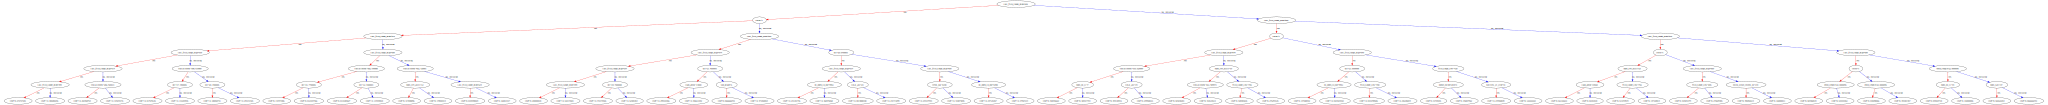

In [ ]:
image = xgb.to_graphviz(xgb_clf)
image

In [ ]:
df = pd.DataFrame(xgb_clf.get_booster().get_score(importance_type = "weight"),
             index = ["raw importance"]).T
df['percentage'] = df["raw importance"]/sum(df["raw importance"])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55 entries, loan_amnt to total_il_high_credit_limit
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   raw importance  55 non-null     float64
 1   percentage      55 non-null     float64
dtypes: float64(2)
memory usage: 1.3+ KB


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

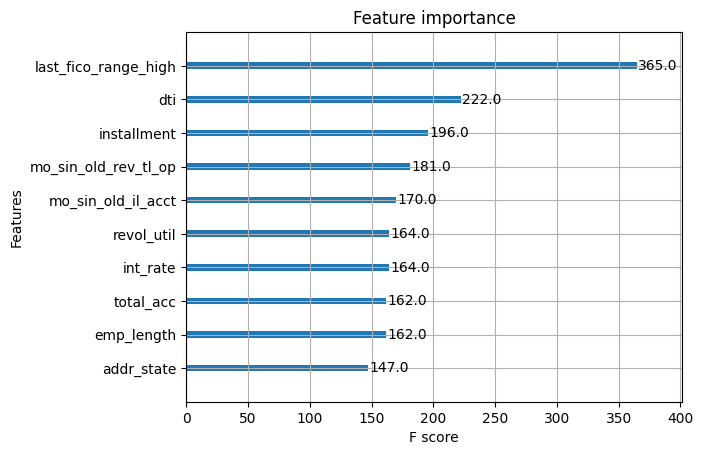

In [ ]:
plot_importance(xgb_clf, max_num_features = 10)

In [ ]:
df = df.sort_values(by=['percentage'], ascending=False)
df['cumulative percentage'] = df['percentage'].cumsum()/ df['percentage'].sum()*100

#columns_titles = ["feature", "raw importance", "percentage", "cumulative percentage"]
#df=df.reindex(columns=columns_titles)

In [ ]:
#90% feature importances
df90 = df[df['cumulative percentage'] <= 90]
df90.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39 entries, last_fico_range_high to num_op_rev_tl
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   raw importance         39 non-null     float64
 1   percentage             39 non-null     float64
 2   cumulative percentage  39 non-null     float64
dtypes: float64(3)
memory usage: 1.2+ KB


In [ ]:
#80% feature importances
df80 = df[df['cumulative percentage'] <= 80]
df80.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31 entries, last_fico_range_high to term
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   raw importance         31 non-null     float64
 1   percentage             31 non-null     float64
 2   cumulative percentage  31 non-null     float64
dtypes: float64(3)
memory usage: 992.0+ bytes


In [ ]:
#70% feature importances
df70 = df[df['cumulative percentage'] <= 70]
df70.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25 entries, last_fico_range_high to mo_sin_rcnt_rev_tl_op
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   raw importance         25 non-null     float64
 1   percentage             25 non-null     float64
 2   cumulative percentage  25 non-null     float64
dtypes: float64(3)
memory usage: 800.0+ bytes


Để đảm bảo rằng số lượng thuộc tính vừa phải và cũng vừa đủ sức ảnh hưởng đến các mô hình của chúng ta, nhóm sẽ lựa chọn các thuộc tính chiếm 70% feature importances, tổng cộng là 25 thuộc tính

In [ ]:
df70

,raw importance,percentage,cumulative percentage
last_fico_range_high,365.00,0.07,6.77
dti,222.00,0.04,10.89
installment,196.00,0.04,14.52
mo_sin_old_rev_tl_op,181.00,0.03,17.88
mo_sin_old_il_acct,170.00,0.03,21.04
int_rate,164.00,0.03,24.08
revol_util,164.00,0.03,27.12
emp_length,162.00,0.03,30.12
total_acc,162.00,0.03,33.13
addr_state,147.00,0.03,35.86


In [ ]:
print(df70.index)

Index(['last_fico_range_high', 'dti', 'installment', 'mo_sin_old_rev_tl_op',
       'mo_sin_old_il_acct', 'int_rate', 'revol_util', 'emp_length',
       'total_acc', 'addr_state', 'fico_range_low', 'mths_since_recent_inq',
       'annual_inc', 'avg_cur_bal', 'total_il_high_credit_limit',
       'bc_open_to_buy', 'revol_bal', 'bc_util', 'total_bc_limit',
       'tot_hi_cred_lim', 'mths_since_recent_bc', 'total_rev_hi_lim',
       'earliest_cr_line', 'num_il_tl', 'mo_sin_rcnt_rev_tl_op'],
      dtype='object')


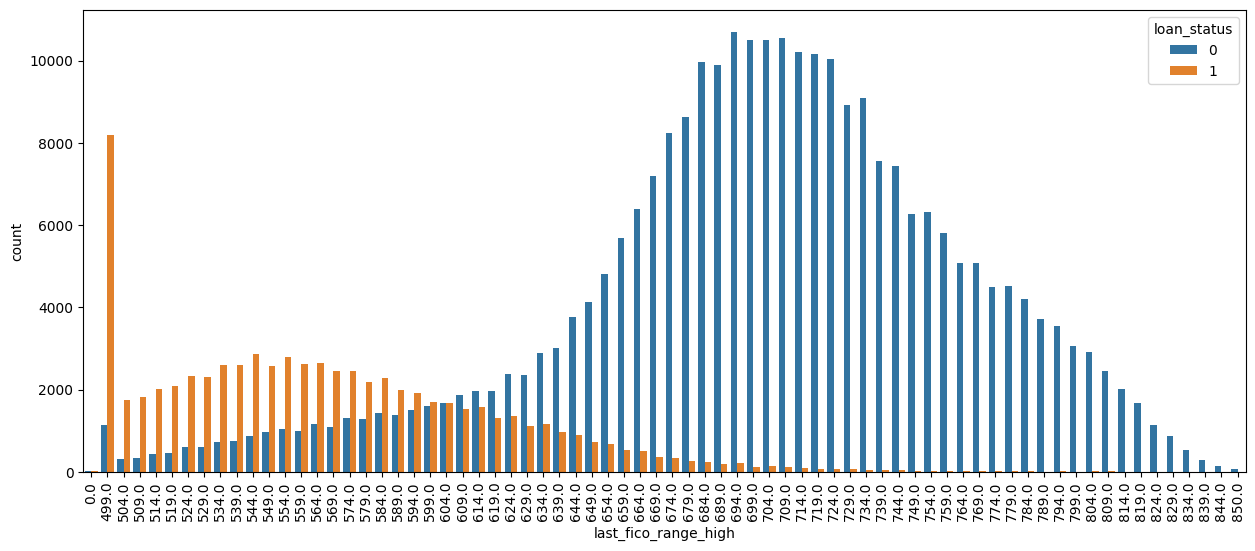

In [ ]:
plt.figure(figsize=(15,6))
last_fico_range_high = sorted(data.last_fico_range_high.unique().tolist())
g = sns.countplot(x='last_fico_range_high', data=data, hue='loan_status', order=last_fico_range_high)
g.set_xticklabels(g.get_xticklabels(), rotation=90);

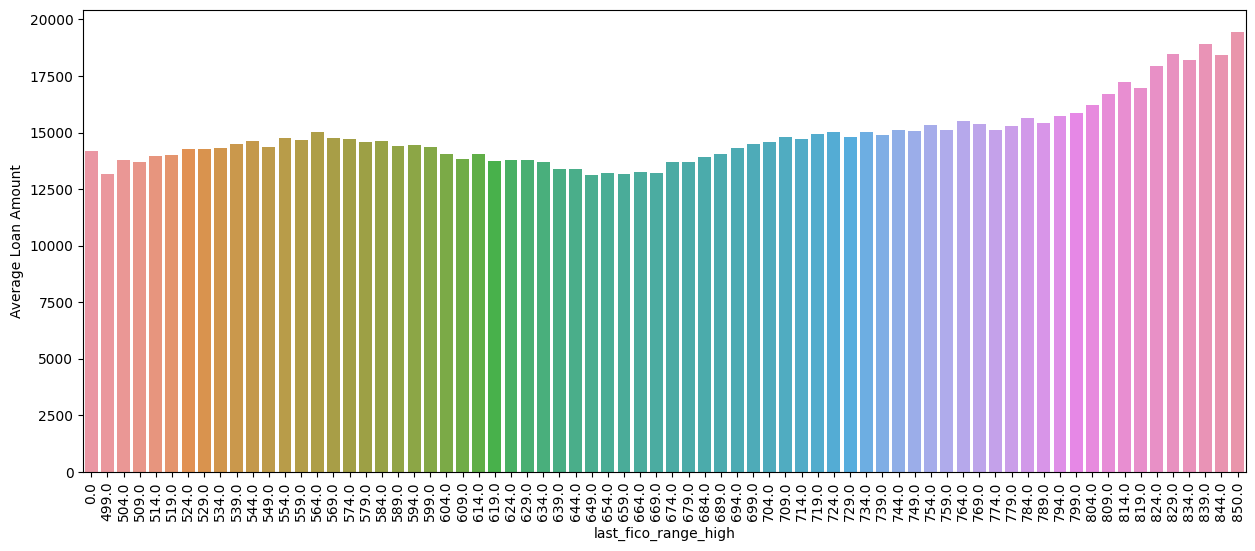

In [ ]:
plt.figure(figsize=(15,6))
means_last_fico_range_high = data.groupby(["last_fico_range_high"]).mean()['loan_amnt'].reset_index(name="Average Loan Amount").sort_values(by='Average Loan Amount', ascending=False)
g = sns.barplot(data=means_last_fico_range_high, x="last_fico_range_high", y="Average Loan Amount")
g.set_xticklabels(g.get_xticklabels(), rotation=90);

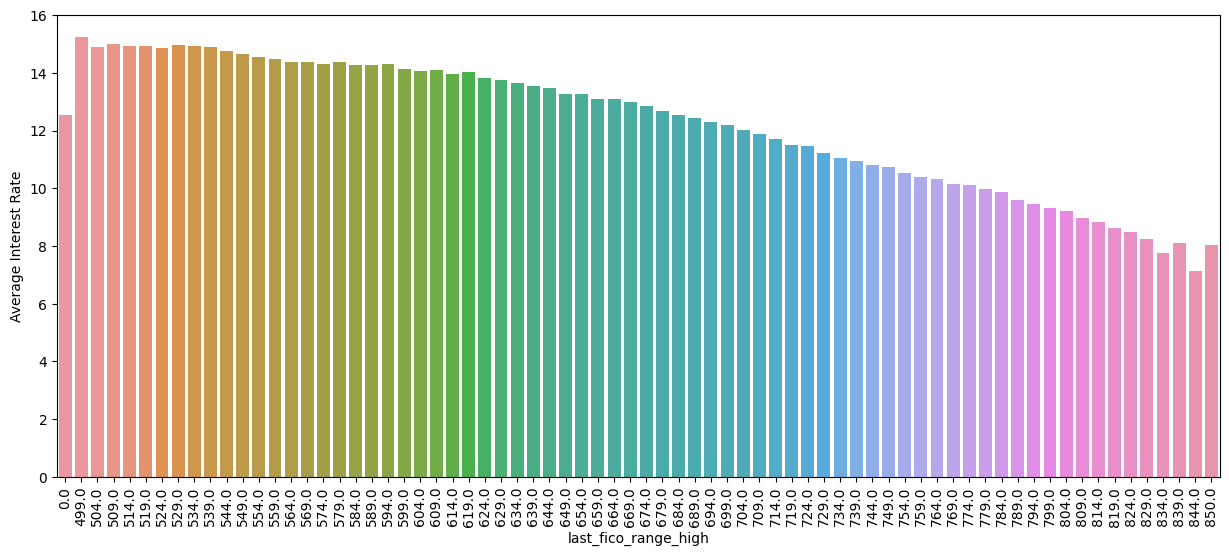

In [ ]:
plt.figure(figsize=(15,6))
means_last_fico_range_high = data.groupby(["last_fico_range_high"]).mean()['int_rate'].reset_index(name="Average Interest Rate").sort_values(by='Average Interest Rate', ascending=False)
g = sns.barplot(data=means_last_fico_range_high, x="last_fico_range_high", y="Average Interest Rate")
g.set_xticklabels(g.get_xticklabels(), rotation=90);

<ipython-input-62-4e1ff09730c1>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels());


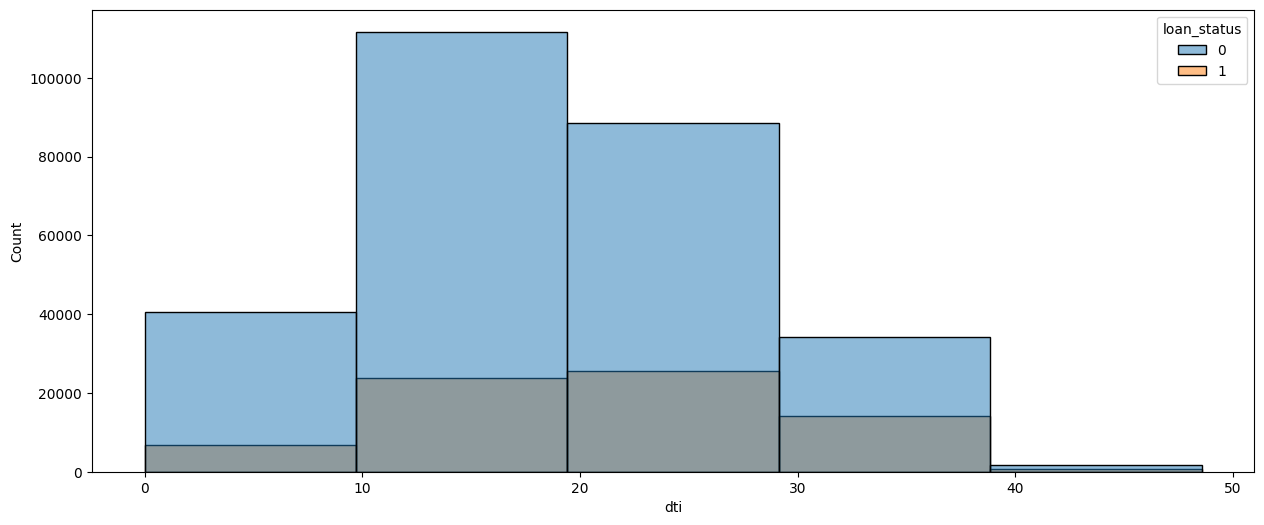

In [ ]:
plt.figure(figsize=(15,6))
g = sns.histplot(data=data, x="dti", hue="loan_status", bins=5)
g.set_xticklabels(g.get_xticklabels());

## 3.5.3. Lựa chọn thuộc tính

Thực hiện chọn các features đã lọc ra từ trước

In [ ]:
keep_list = ['last_fico_range_high', 'dti', 'installment', 'mo_sin_old_il_acct',
             'mo_sin_old_rev_tl_op', 'annual_inc', 'emp_length', 'revol_util',
             'int_rate', 'total_acc', 'addr_state', 'bc_open_to_buy',
             'total_il_high_credit_limit', 'mths_since_recent_inq',
             'mths_since_recent_bc', 'revol_bal', 'bc_util', 'loan_amnt',
             'total_rev_hi_lim', 'fico_range_low', 'mo_sin_rcnt_rev_tl_op',
             'total_bal_ex_mort', 'earliest_cr_line', 'pct_tl_nvr_dlq',
             'avg_cur_bal', 'loan_status']

drop_list = [col for col in data.columns if col not in keep_list]
data.drop(labels=drop_list, axis=1, inplace=True)

<Axes: >

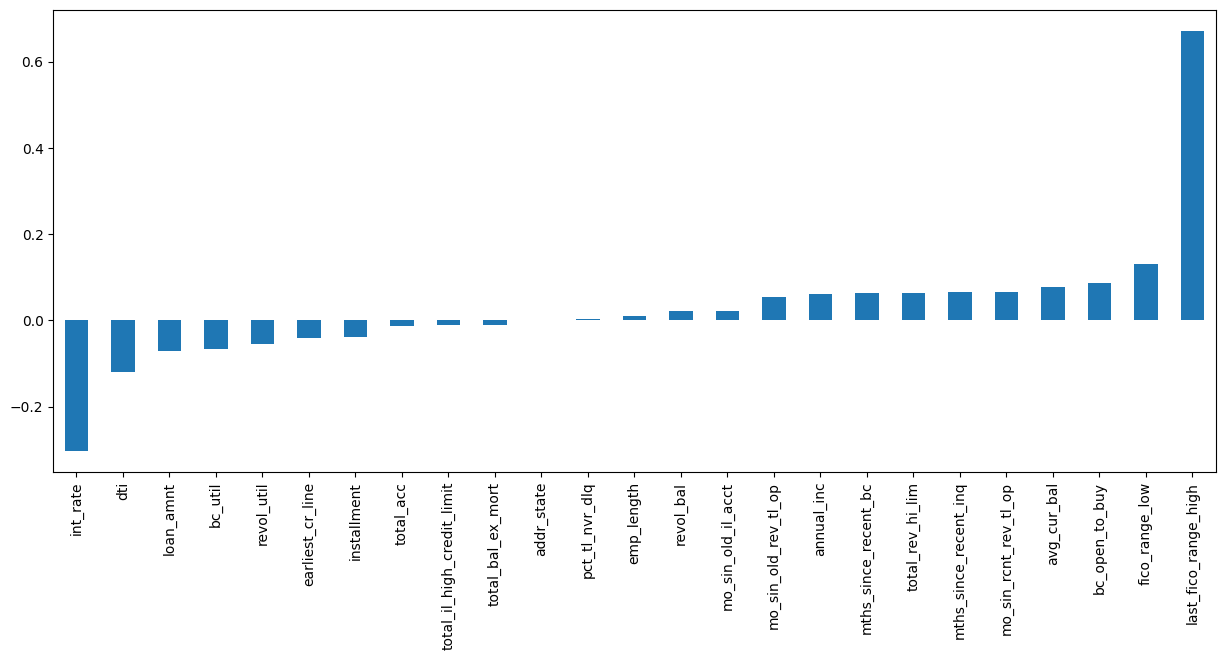

In [ ]:
data.corr()['loan_status'].drop('loan_status').sort_values().plot(kind='bar', figsize=(15,6))

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 347533 entries, 0 to 375544
Data columns (total 26 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   loan_amnt                   347533 non-null  float64
 1   int_rate                    347533 non-null  float64
 2   installment                 347533 non-null  float64
 3   emp_length                  327910 non-null  float64
 4   annual_inc                  347533 non-null  float64
 5   loan_status                 347533 non-null  int64  
 6   addr_state                  347533 non-null  int64  
 7   dti                         347533 non-null  float64
 8   earliest_cr_line            347533 non-null  int64  
 9   fico_range_low              347533 non-null  float64
 10  revol_bal                   347533 non-null  float64
 11  revol_util                  347533 non-null  float64
 12  total_acc                   347533 non-null  float64
 13  last_fico_rang

# 3.6. Tiếp tục xử lý dữ liệu

##3.6.1. Correlation Heatmap

<Axes: >

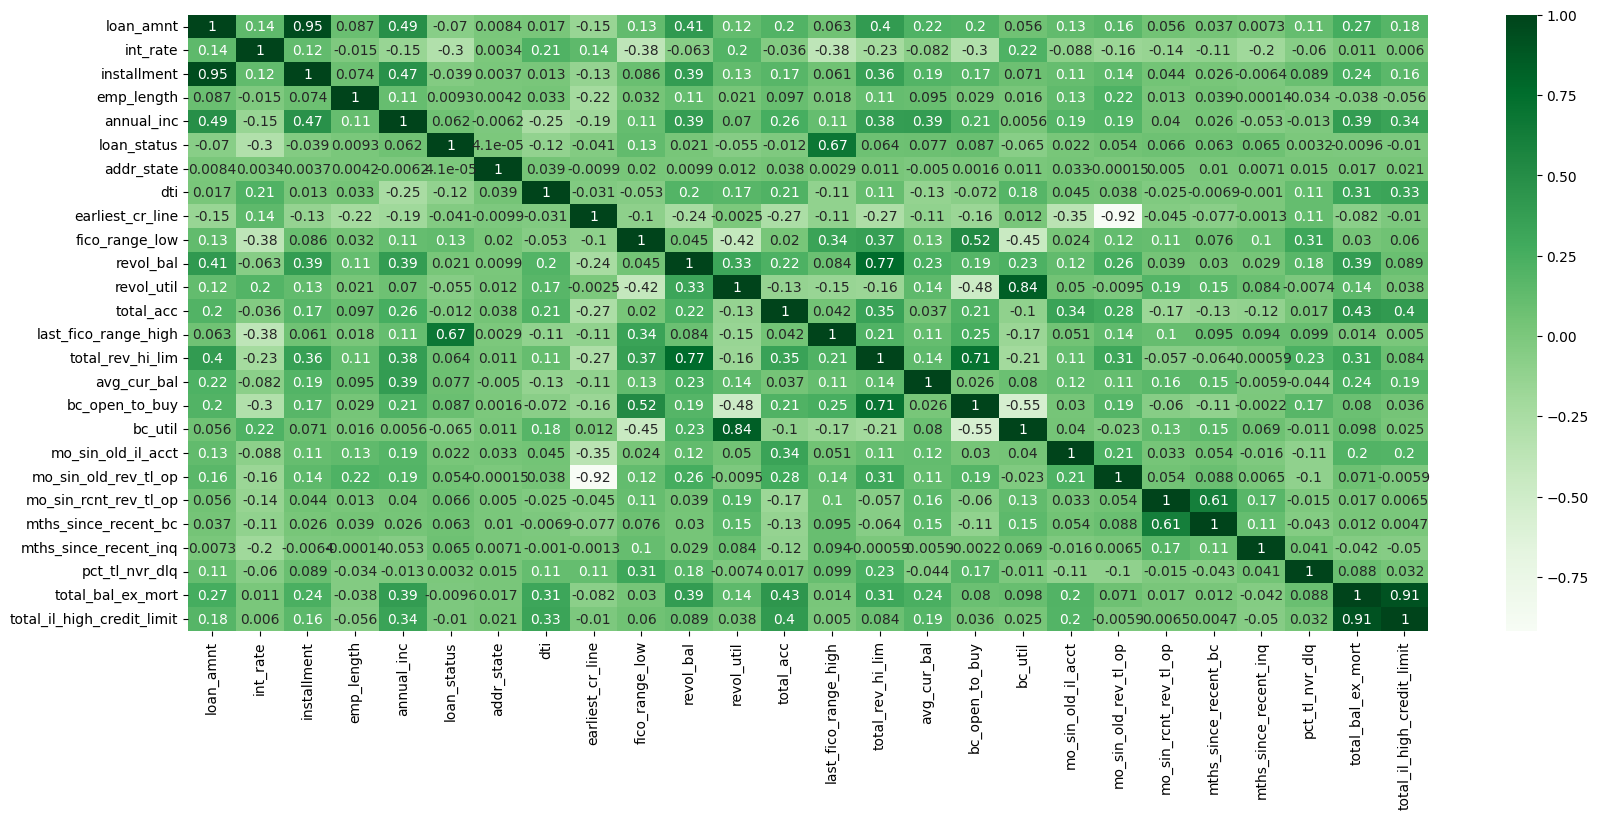

In [ ]:
plt.figure(figsize=(20, 8))
sns.heatmap(data.corr(), annot=True, cmap='Greens')

Để giảm bớt số lượng thuộc tính không cần thiết, chúng ta sẽ loại bỏ 1 biến trong các features với correlation trên 0.9

In [ ]:
cor_matrix = data.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))

<ipython-input-117-442a126e56c2>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))


In [ ]:
#0.9
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]
print(to_drop)

['installment', 'mo_sin_old_rev_tl_op', 'total_il_high_credit_limit']


In [ ]:
data.drop(columns=to_drop, axis=1, inplace=True)

##3.6.2. Xử lý dữ liệu trống


In [ ]:
# Missing values
for column in data.columns:
    if data[column].isna().sum() != 0:
        missing = data[column].isna().sum()
        portion = (missing / data.shape[0]) * 100
        print(f"'{column}': number of missing values '{missing}' ==> '{portion:.3f}%'")

'emp_length': number of missing values '19623' ==> '5.646%'
'mths_since_recent_inq': number of missing values '34803' ==> '10.014%'


In [ ]:
for year in sorted(data.emp_length.unique()):
    print(f"{year} years in this position:")
    print(f"{data[data.emp_length == year].loan_status.value_counts(normalize=True)}")
    print('==========================================')

0.0 years in this position:
1   0.80
0   0.20
Name: loan_status, dtype: float64
1.0 years in this position:
1   0.79
0   0.21
Name: loan_status, dtype: float64
2.0 years in this position:
1   0.80
0   0.20
Name: loan_status, dtype: float64
3.0 years in this position:
1   0.80
0   0.20
Name: loan_status, dtype: float64
4.0 years in this position:
1   0.79
0   0.21
Name: loan_status, dtype: float64
5.0 years in this position:
1   0.80
0   0.20
Name: loan_status, dtype: float64
6.0 years in this position:
1   0.80
0   0.20
Name: loan_status, dtype: float64
7.0 years in this position:
1   0.79
0   0.21
Name: loan_status, dtype: float64
8.0 years in this position:
1   0.79
0   0.21
Name: loan_status, dtype: float64
9.0 years in this position:
1   0.79
0   0.21
Name: loan_status, dtype: float64
11.0 years in this position:
1   0.81
0   0.19
Name: loan_status, dtype: float64
nan years in this position:
Series([], Name: loan_status, dtype: float64)


Tỷ lệ giữa 2 giá trị loan_status số năm làm việc khác nhau là tương tự nhau, ta có thể tự tin loại bỏ cột này mà không gây ảnh hưởng gì đến kết quả

In [ ]:
data.drop(columns=['emp_length'], axis=1, inplace=True)

In [ ]:
for month in sorted(data.mths_since_recent_inq.unique()):
    print(f"{month} months since last inquiry:")
    print(f"{data[data.mths_since_recent_inq == month].loan_status.value_counts(normalize=True)}")
    print('==========================================')

0.0 months since last inquiry:
1   0.75
0   0.25
Name: loan_status, dtype: float64
1.0 months since last inquiry:
1   0.75
0   0.25
Name: loan_status, dtype: float64
2.0 months since last inquiry:
1   0.77
0   0.23
Name: loan_status, dtype: float64
4.0 months since last inquiry:
1   0.79
0   0.21
Name: loan_status, dtype: float64
5.0 months since last inquiry:
1   0.79
0   0.21
Name: loan_status, dtype: float64
6.0 months since last inquiry:
1   0.80
0   0.20
Name: loan_status, dtype: float64
7.0 months since last inquiry:
1   0.80
0   0.20
Name: loan_status, dtype: float64
9.0 months since last inquiry:
1   0.81
0   0.19
Name: loan_status, dtype: float64
10.0 months since last inquiry:
1   0.81
0   0.19
Name: loan_status, dtype: float64
nan months since last inquiry:
Series([], Name: loan_status, dtype: float64)
3.0 months since last inquiry:
1   0.77
0   0.23
Name: loan_status, dtype: float64
8.0 months since last inquiry:
1   0.80
0   0.20
Name: loan_status, dtype: float64
11.0 mont

Với thời gian thẩm định tín dụng gần nhất khác nhau thì có sự chênh lệch nhẹ giữa 2 giá trị loan_status, nhìn chung xu hướng là càng được thẩm định gần thì khả năng trả nợ càng cao. Tuy nhiên, lượng dữ liệu bị thiếu cũng là khá lớn (34000), nhóm quyết định sẽ loại bỏ luôn cột này

In [ ]:
data.drop(columns=['mths_since_recent_inq'], axis=1, inplace=True)

## 3.6.3. Train Test Split

In [ ]:
train, test = train_test_split(data, test_size=0.2, random_state=42)

print(train.shape)
print(test.shape)

(278026, 21)
(69507, 21)


In [ ]:
X_train, y_train = train.drop('loan_status', axis=1), train.loan_status
X_test, y_test = test.drop('loan_status', axis=1), test.loan_status

## 3.6.4. Feature Scaling

In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
X_train = np.array(X_train).astype(np.float32)
X_test = np.array(X_test).astype(np.float32)
y_train = np.array(y_train).astype(np.float32)
y_test = np.array(y_test).astype(np.float32)

#3.7. Xây dựng mô hình

## 3.7.1. XGBoost Classifier

In [ ]:
xgb_clf = XGBClassifier(tree_method="hist")

start = time.time()
xgb_clf.fit(X_train, y_train)
end = time.time()
xgbElapsedTime = end - start

y_train_pred = xgb_clf.predict(X_train)
y_test_pred = xgb_clf.predict(X_test)

time_dict = {
    'XGBoost': [
        xgbElapsedTime,
    ],
}

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

Train Result:
Accuracy Score: 91.92%
_______________________________________________
CLASSIFICATION REPORT:
               0.0       1.0  accuracy  macro avg  weighted avg
precision     0.80      0.95      0.92       0.87          0.92
recall        0.81      0.95      0.92       0.88          0.92
f1-score      0.80      0.95      0.92       0.88          0.92
support   56801.00 221225.00      0.92  278026.00     278026.00
_______________________________________________
Confusion Matrix: 
 [[ 46235  10566]
 [ 11895 209330]]

Test Result:
Accuracy Score: 90.56%
_______________________________________________
CLASSIFICATION REPORT:
               0.0      1.0  accuracy  macro avg  weighted avg
precision     0.76     0.94      0.91       0.85          0.91
recall        0.78     0.94      0.91       0.86          0.91
f1-score      0.77     0.94      0.91       0.85          0.91
support   14018.00 55489.00      0.91   69507.00      69507.00
______________________________________________

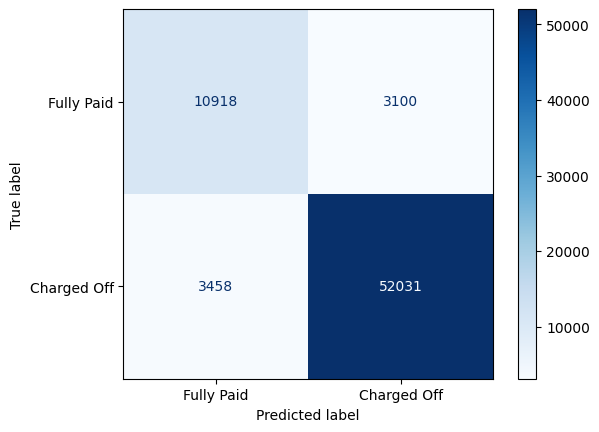

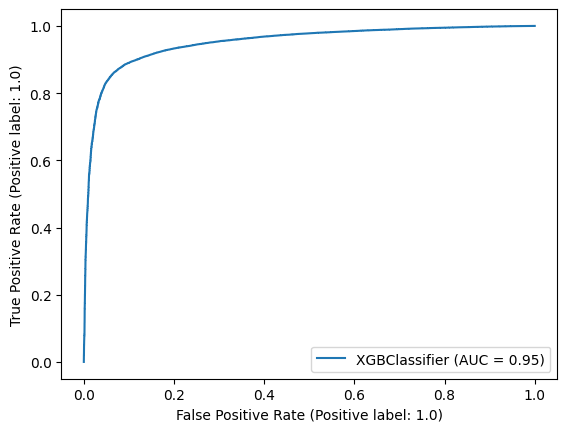

In [ ]:
disp = ConfusionMatrixDisplay.from_estimator(
    xgb_clf, X_test, y_test, 
    cmap='Blues', values_format='d', 
    display_labels=['Fully Paid', 'Charged Off']
)

disp = RocCurveDisplay.from_estimator(xgb_clf, X_test, y_test)

In [ ]:
scores_dict_auc = {
    'XGBoost': {
        'Train': roc_auc_score(y_train, xgb_clf.predict_proba(X_train)[:,1]),
        'Test': roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1]),
    },
}

scores_dict_acc = {
    'XGBoost': {
        'Train': accuracy_score(y_train, y_train_pred),
        'Test': accuracy_score(y_test, y_test_pred),
    },
}

scores_dict_f1 = {
    'XGBoost': {
        'Train': 0.80,
        'Test': 0.77,
    },
}    

## 3.7.2. Random Forest Classifier

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=100)

start = time.time()
rf_clf.fit(X_train, y_train)
end = time.time()
rfElapsedTime = end - start

y_train_pred = rf_clf.predict(X_train)
y_test_pred = rf_clf.predict(X_test)

time_dict['Random Forest'] = [
        rfElapsedTime,
]

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
               0.0       1.0  accuracy  macro avg  weighted avg
precision     1.00      1.00      1.00       1.00          1.00
recall        1.00      1.00      1.00       1.00          1.00
f1-score      1.00      1.00      1.00       1.00          1.00
support   56801.00 221225.00      1.00  278026.00     278026.00
_______________________________________________
Confusion Matrix: 
 [[ 56800      1]
 [     0 221225]]

Test Result:
Accuracy Score: 90.51%
_______________________________________________
CLASSIFICATION REPORT:
               0.0      1.0  accuracy  macro avg  weighted avg
precision     0.76     0.94      0.91       0.85          0.91
recall        0.78     0.94      0.91       0.86          0.91
f1-score      0.77     0.94      0.91       0.85          0.91
support   14018.00 55489.00      0.91   69507.00      69507.00
_____________________________________________

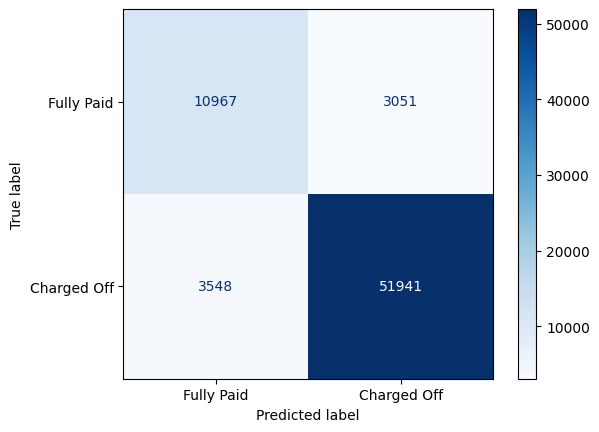

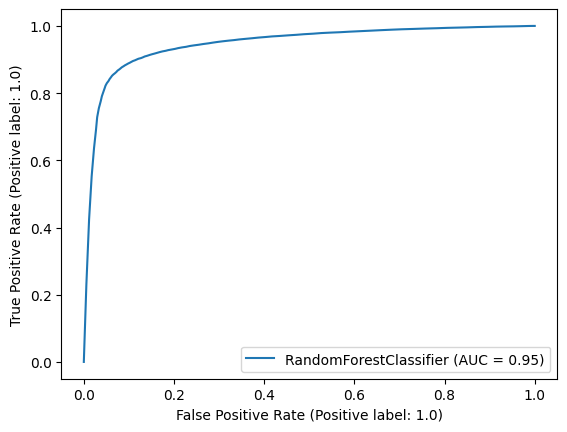

In [ ]:
disp = ConfusionMatrixDisplay.from_estimator(rf_clf, X_test, y_test, 
                             cmap='Blues', values_format='d', 
                             display_labels=['Fully Paid', 'Charged Off'])

disp = RocCurveDisplay.from_estimator(rf_clf, X_test, y_test)

In [ ]:
scores_dict_auc['Random Forest'] = {
        'Train': roc_auc_score(y_train, rf_clf.predict_proba(X_train)[:,1]),
        'Test': roc_auc_score(y_test, rf_clf.predict_proba(X_test)[:,1]),
    }

scores_dict_acc['Random Forest'] = {
        'Train': accuracy_score(y_train, y_train_pred),
        'Test': accuracy_score(y_test, y_test_pred),
    }

scores_dict_f1['Random Forest'] = {
        'Train': 1.00,
        'Test': 0.77,
    }   

## 3.7.3. Logistic Regression

In [ ]:
log_reg = LogisticRegression()

start = time.time()
log_reg.fit(X_train, y_train)
end = time.time()
logElapsedTime = end - start

y_train_pred = log_reg.predict(X_train)
y_test_pred = log_reg.predict(X_test)

time_dict['Logistic Regression'] = [
        logElapsedTime,
]

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

Train Result:
Accuracy Score: 90.21%
_______________________________________________
CLASSIFICATION REPORT:
               0.0       1.0  accuracy  macro avg  weighted avg
precision     0.78      0.93      0.90       0.86          0.90
recall        0.73      0.95      0.90       0.84          0.90
f1-score      0.75      0.94      0.90       0.85          0.90
support   56801.00 221225.00      0.90  278026.00     278026.00
_______________________________________________
Confusion Matrix: 
 [[ 41228  15573]
 [ 11634 209591]]

Test Result:
Accuracy Score: 90.16%
_______________________________________________
CLASSIFICATION REPORT:
               0.0      1.0  accuracy  macro avg  weighted avg
precision     0.77     0.93      0.90       0.85          0.90
recall        0.72     0.95      0.90       0.83          0.90
f1-score      0.75     0.94      0.90       0.84          0.90
support   14018.00 55489.00      0.90   69507.00      69507.00
______________________________________________

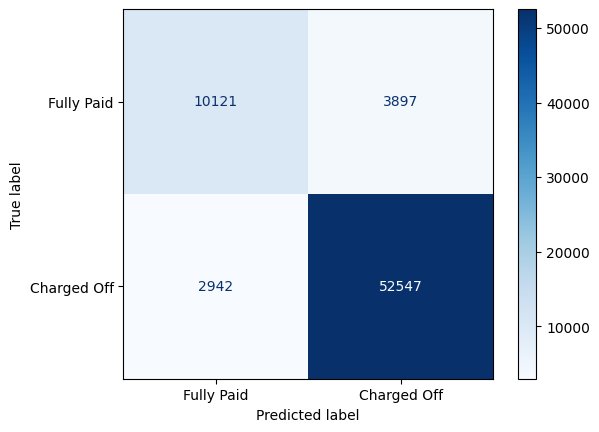

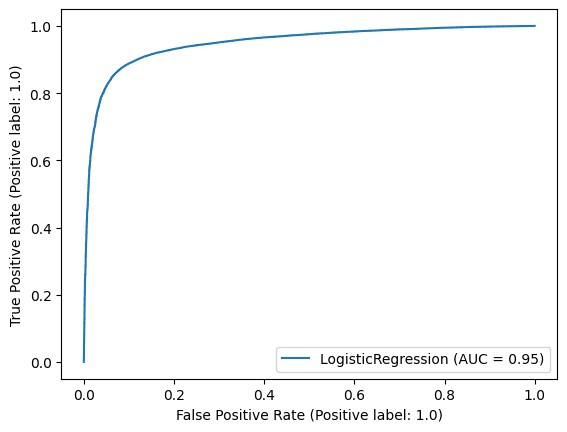

In [ ]:
disp = ConfusionMatrixDisplay.from_estimator(log_reg, X_test, y_test, 
                             cmap='Blues', values_format='d', 
                             display_labels=['Fully Paid', 'Charged Off'])

disp = RocCurveDisplay.from_estimator(log_reg, X_test, y_test)

In [ ]:
scores_dict_auc['Logistic Regression'] = {
        'Train': roc_auc_score(y_train, log_reg.predict_proba(X_train)[:,1]),
        'Test': roc_auc_score(y_test, log_reg.predict_proba(X_test)[:,1]),
    }

scores_dict_acc['Logistic Regression'] = {
        'Train': accuracy_score(y_train, y_train_pred),
        'Test': accuracy_score(y_test, y_test_pred),
    }

scores_dict_f1['Logistic Regression'] = {
        'Train': 0.75,
        'Test': 0.75,
    }

## 3.7.4. Artificial Neural Networks (ANNs)

In [ ]:
def evaluate_nn(true, pred, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        
def plot_learning_evolution(r):
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    plt.plot(r.history['loss'], label='Loss')
    plt.plot(r.history['val_loss'], label='val_Loss')
    plt.title('Loss evolution during training')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(r.history['AUC'], label='AUC')
    plt.plot(r.history['val_AUC'], label='val_AUC')
    plt.title('AUC score evolution during training')
    plt.legend();

def nn_model(num_columns, num_labels, hidden_units, dropout_rates, learning_rate):
    inp = tf.keras.layers.Input(shape=(num_columns, ))
    x = BatchNormalization()(inp)
    x = Dropout(dropout_rates[0])(x)
    for i in range(len(hidden_units)):
       x = Dense(hidden_units[i], activation='relu')(x)
       x = BatchNormalization()(x)
       x = Dropout(dropout_rates[i + 1])(x)
    x = Dense(num_labels, activation='sigmoid')(x)
  
    model = Model(inputs=inp, outputs=x)
    model.compile(optimizer=Adam(learning_rate), loss='binary_crossentropy', metrics=[AUC(name='AUC')])
    return model

In [ ]:
num_columns = X_train.shape[1]
num_labels = 1
hidden_units = [150, 150, 150]
dropout_rates = [0.1, 0, 0.1, 0]
learning_rate = 1e-3

model = nn_model(
    num_columns=num_columns, 
    num_labels=num_labels,
    hidden_units=hidden_units,
    dropout_rates=dropout_rates,
    learning_rate=learning_rate
)

start = time.time()

r = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32
)

end = time.time()
annElapsedTime = end - start

time_dict['ANN'] = [
        annElapsedTime,
]

Epoch 1/20
8689/8689 [==============================] - 44s 5ms/step - loss: 0.2717 - AUC: 0.9255 - val_loss: 0.2241 - val_AUC: 0.9496
Epoch 2/20
8689/8689 [==============================] - 47s 5ms/step - loss: 0.2613 - AUC: 0.9311 - val_loss: 0.2241 - val_AUC: 0.9507
Epoch 3/20
8689/8689 [==============================] - 44s 5ms/step - loss: 0.2576 - AUC: 0.9331 - val_loss: 0.2252 - val_AUC: 0.9508
Epoch 4/20
8689/8689 [==============================] - 34s 4ms/step - loss: 0.2564 - AUC: 0.9338 - val_loss: 0.2219 - val_AUC: 0.9507
Epoch 5/20
8689/8689 [==============================] - 41s 5ms/step - loss: 0.2556 - AUC: 0.9342 - val_loss: 0.2256 - val_AUC: 0.9509
Epoch 6/20
8689/8689 [==============================] - 44s 5ms/step - loss: 0.2543 - AUC: 0.9350 - val_loss: 0.2242 - val_AUC: 0.9508
Epoch 7/20
8689/8689 [==============================] - 51s 6ms/step - loss: 0.2536 - AUC: 0.9353 - val_loss: 0.2258 - val_AUC: 0.9507
Epoch 8/20
8689/8689 [==============================] -

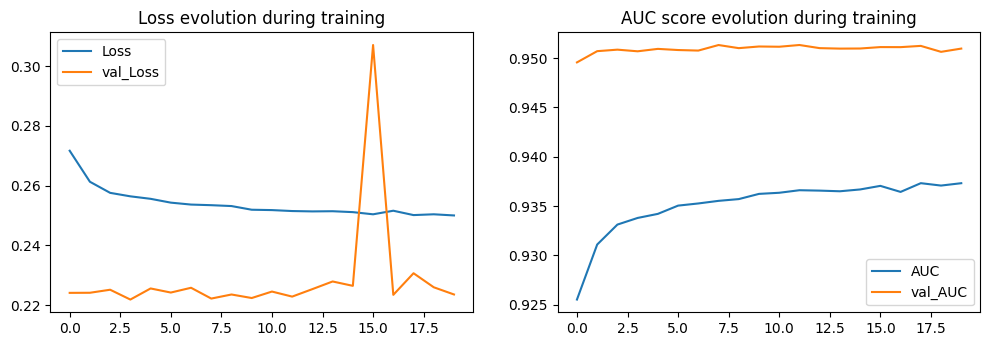

In [ ]:
plot_learning_evolution(r)

In [ ]:
y_train_pred = model.predict(X_train)
evaluate_nn(y_train, y_train_pred.round(), train=True)

y_test_pred = model.predict(X_test)
evaluate_nn(y_test, y_test_pred.round(), train=False)

8689/8689 [==============================] - 15s 2ms/step
Train Result:
Accuracy Score: 90.55%
_______________________________________________
CLASSIFICATION REPORT:
               0.0       1.0  accuracy  macro avg  weighted avg
precision     0.78      0.94      0.91       0.86          0.90
recall        0.74      0.95      0.91       0.85          0.91
f1-score      0.76      0.94      0.91       0.85          0.90
support   56801.00 221225.00      0.91  278026.00     278026.00
_______________________________________________
Confusion Matrix: 
 [[ 42290  14511]
 [ 11751 209474]]

2173/2173 [==============================] - 3s 1ms/step
Test Result:
Accuracy Score: 90.44%
_______________________________________________
CLASSIFICATION REPORT:
               0.0      1.0  accuracy  macro avg  weighted avg
precision     0.78     0.93      0.90       0.86          0.90
recall        0.74     0.95      0.90       0.84          0.90
f1-score      0.76     0.94      0.90       0.85         

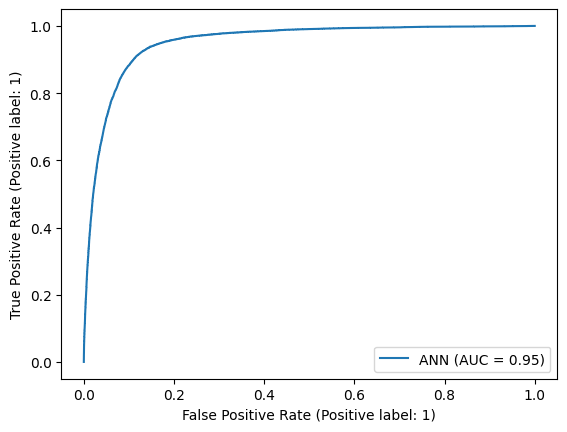

In [ ]:
display = RocCurveDisplay.from_predictions(y_test, y_test_pred, name="ANN")

In [ ]:
scores_dict_auc['ANN'] = {
        'Train': roc_auc_score(y_train, y_train_pred),
        'Test': roc_auc_score(y_test, y_test_pred),
    }

scores_dict_acc['ANN'] = {
        'Train': 0.9055,
        'Test': 0.9044,
    }

scores_dict_f1['ANN'] = {
        'Train': 0.76,
        'Test': 0.76,
    }

# 3.8. So sánh và đánh giá

##3.8.1. AUC score

[Text(0, 0, '0.952'), Text(0, 0, '0.951033')]

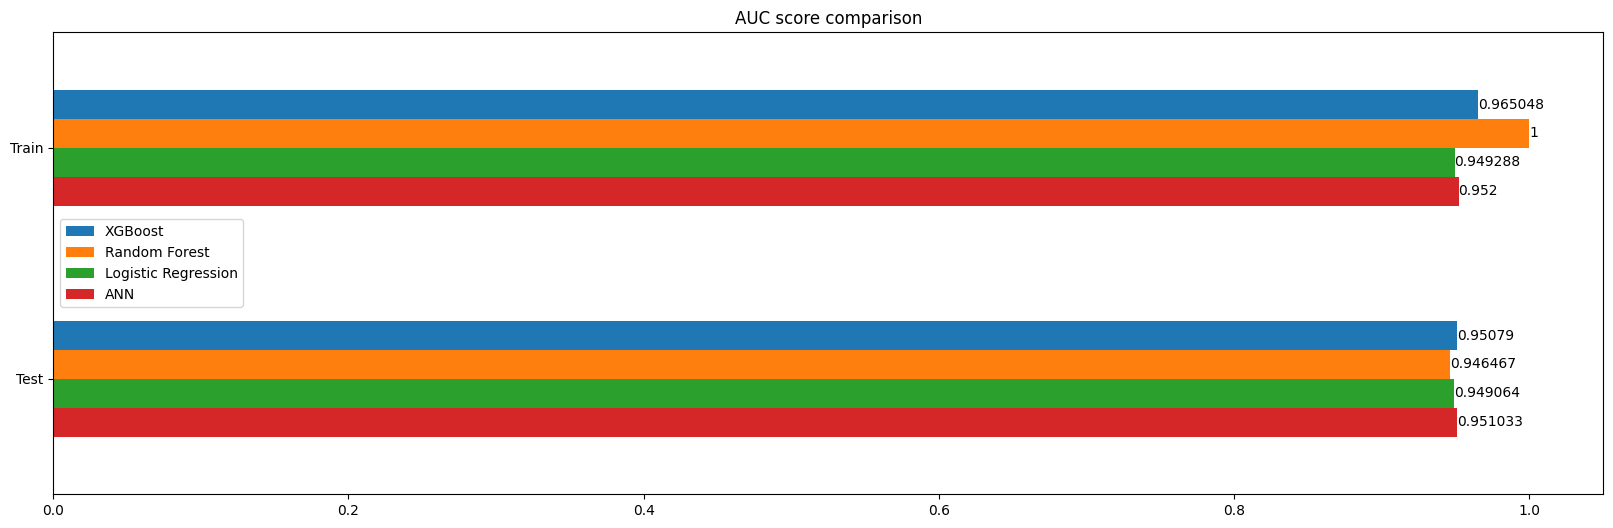

In [ ]:
scores_auc_df = pd.DataFrame(scores_dict_auc)

ax = scores_auc_df.plot(kind='barh', title='AUC score comparison', figsize=(20, 6))
ax.legend(loc='center left')
ax.invert_yaxis()
ax.bar_label(ax.containers[0], label_type='edge')
ax.bar_label(ax.containers[1], label_type='edge')
ax.bar_label(ax.containers[2], label_type='edge')
ax.bar_label(ax.containers[3], label_type='edge')

##3.8.2. Accuracy score

[Text(0, 0, '0.9055'), Text(0, 0, '0.9044')]

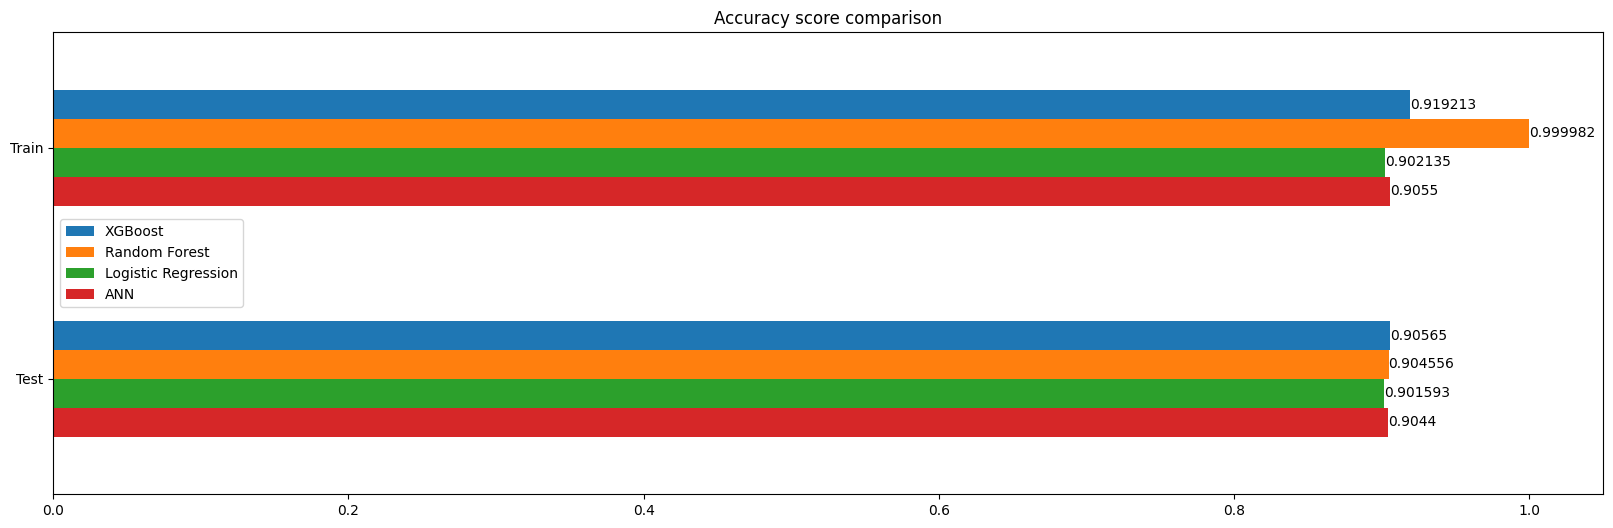

In [ ]:
scores_acc_df = pd.DataFrame(scores_dict_acc)

ax = scores_acc_df.plot(kind='barh', title='Accuracy score comparison', figsize=(20, 6))
ax.legend(loc='center left')
ax.invert_yaxis()
ax.bar_label(ax.containers[0], label_type='edge')
ax.bar_label(ax.containers[1], label_type='edge')
ax.bar_label(ax.containers[2], label_type='edge')
ax.bar_label(ax.containers[3], label_type='edge')

##3.8.3. F1-Score

[Text(0, 0, '0.76'), Text(0, 0, '0.76')]

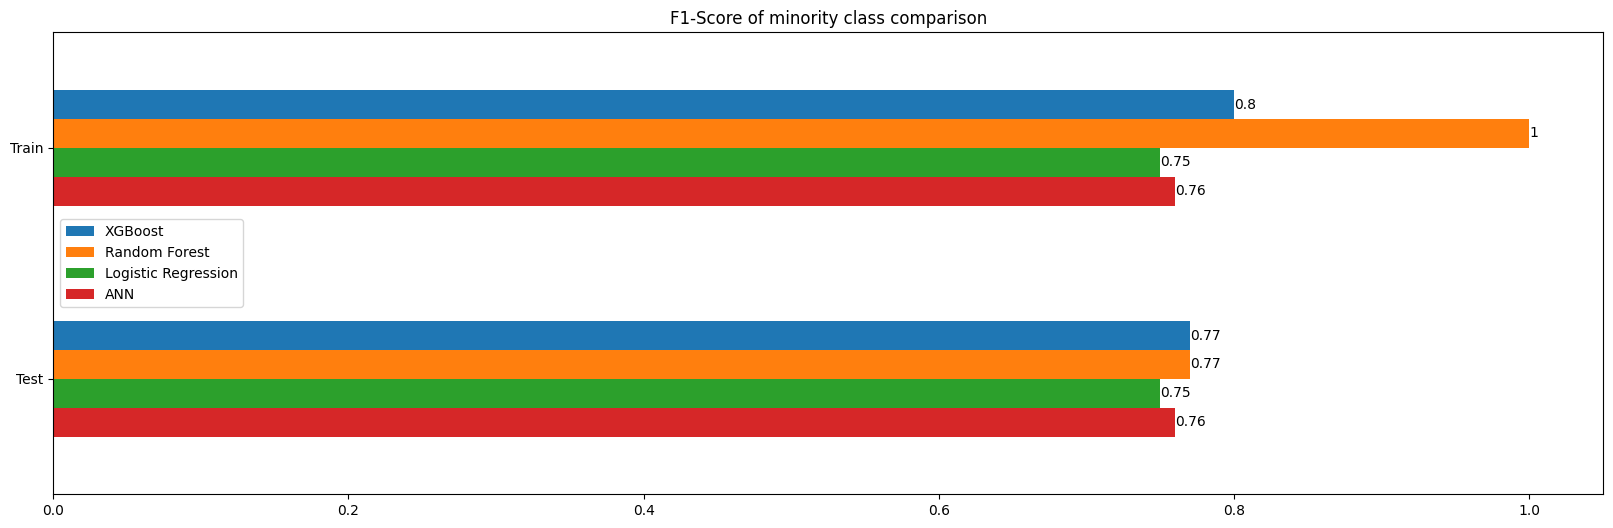

In [ ]:
scores_f1_df = pd.DataFrame(scores_dict_f1)

ax = scores_f1_df.plot(kind='barh', title='F1-Score of minority class comparison', figsize=(20, 6))
ax.legend(loc='center left')
ax.invert_yaxis()
ax.bar_label(ax.containers[0], label_type='edge')
ax.bar_label(ax.containers[1], label_type='edge')
ax.bar_label(ax.containers[2], label_type='edge')
ax.bar_label(ax.containers[3], label_type='edge')

##3.8.4. Elapsed Time

[Text(0, 0, '744.811')]

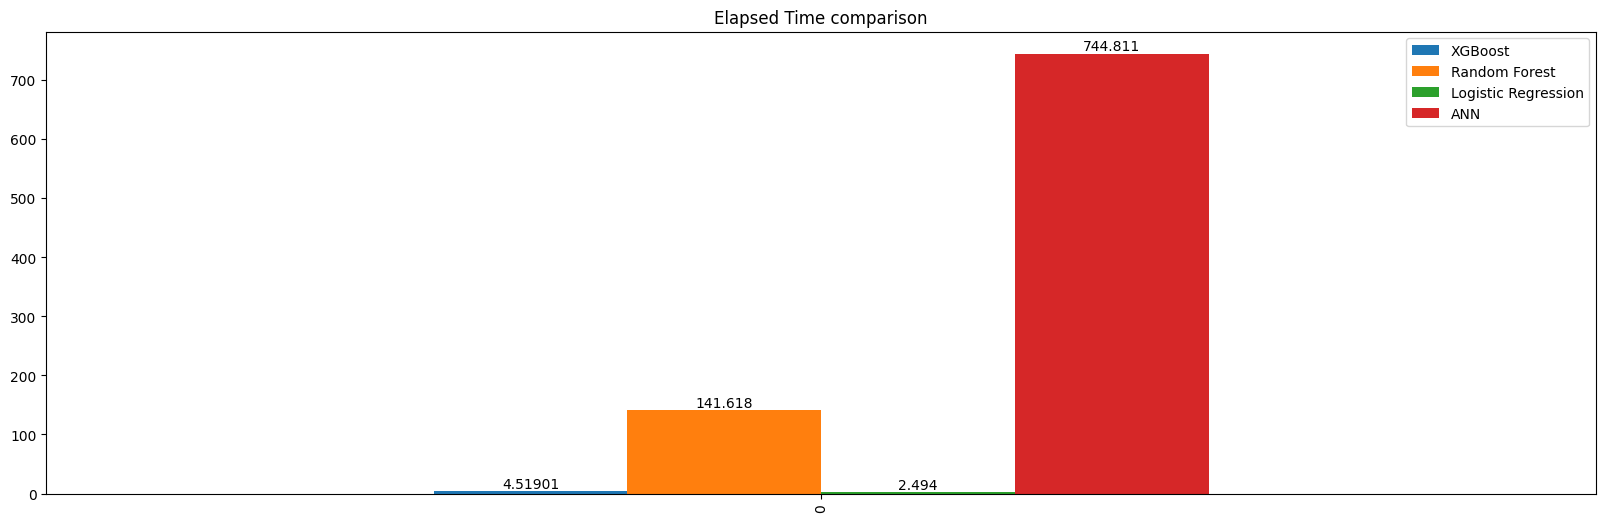

In [ ]:
time_df = pd.DataFrame(time_dict)

ax = time_df.plot(kind='bar', title='Elapsed Time comparison', figsize=(20, 6))
ax.bar_label(ax.containers[0], label_type='edge')
ax.bar_label(ax.containers[1], label_type='edge')
ax.bar_label(ax.containers[2], label_type='edge')
ax.bar_label(ax.containers[3], label_type='edge')

#3.9. Tối ưu hoá tham số

In [ ]:
!nvidia-smi 

Wed Apr  5 10:00:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   78C    P0    33W /  70W |    237MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
params = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01,0.05,0.1],
    'booster': ['gbtree', 'gblinear'],
    'gamma': [0, 0.5, 1],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [0.5, 1, 5],
    'base_score': [0.2, 0.5, 1]
}

gs2 = RandomizedSearchCV(XGBClassifier(n_jobs=-1, tree_method='gpu_hist'), params, n_jobs=-1, cv=KFold(n_splits=3), scoring='roc_auc')
start = time.time()
gs2.fit(X_train, y_train)
end = time.time()
xgbElapsedTime = end - start

y_train_pred = gs2.predict(X_train)
y_test_pred = gs2.predict(X_test)

time_dict = {
    'XGBoost': [
        xgbElapsedTime,
    ],
}

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)
print('Best score:', gs2.best_score_)
print('Best score:', gs2.best_params_)

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/dist-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.9/dist-packages/xgboost/core.py", line 620, in inner_f
    retu

Train Result:
Accuracy Score: 91.04%
_______________________________________________
CLASSIFICATION REPORT:
               0.0       1.0  accuracy  macro avg  weighted avg
precision     0.77      0.95      0.91       0.86          0.91
recall        0.79      0.94      0.91       0.87          0.91
f1-score      0.78      0.94      0.91       0.86          0.91
support   56801.00 221225.00      0.91  278026.00     278026.00
_______________________________________________
Confusion Matrix: 
 [[ 45102  11699]
 [ 13214 208011]]

Test Result:
Accuracy Score: 90.66%
_______________________________________________
CLASSIFICATION REPORT:
               0.0      1.0  accuracy  macro avg  weighted avg
precision     0.76     0.94      0.91       0.85          0.91
recall        0.78     0.94      0.91       0.86          0.91
f1-score      0.77     0.94      0.91       0.86          0.91
support   14018.00 55489.00      0.91   69507.00      69507.00
______________________________________________

In [ ]:
TREE_METHOD = 'gpu_hist'
N_ESTIMATOR = 100
GAMMA = 0.5
LEARNING_RATE = 0.1
BOOSTER = 'gbtree'
BASE_SCORE = 0.2
REG_ALPHA = 0.5
REG_LAMBDA = 5

params2 = {'tree_method': TREE_METHOD,
           'n_estimators': N_ESTIMATOR,
           'gamma': GAMMA,
           'learning_rate': LEARNING_RATE,
           'booster': BOOSTER,
           'base_score' : BASE_SCORE ,
           'reg_alpha': REG_ALPHA,
           'reg_lambda': REG_LAMBDA}

In [ ]:
xgb_clf_tuned = XGBClassifier(**params2)

start = time.time()
xgb_clf_tuned.fit(X_train, y_train)
end = time.time()
xgbElapsedTime = end - start

y_train_pred = xgb_clf_tuned.predict(X_train)
y_test_pred = xgb_clf_tuned.predict(X_test)

time_dict = {
    'XGBoost': [
        xgbElapsedTime,
    ],
}

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

Train Result:
Accuracy Score: 91.04%
_______________________________________________
CLASSIFICATION REPORT:
               0.0       1.0  accuracy  macro avg  weighted avg
precision     0.77      0.95      0.91       0.86          0.91
recall        0.79      0.94      0.91       0.87          0.91
f1-score      0.78      0.94      0.91       0.86          0.91
support   56801.00 221225.00      0.91  278026.00     278026.00
_______________________________________________
Confusion Matrix: 
 [[ 45102  11699]
 [ 13214 208011]]

Test Result:
Accuracy Score: 90.66%
_______________________________________________
CLASSIFICATION REPORT:
               0.0      1.0  accuracy  macro avg  weighted avg
precision     0.76     0.94      0.91       0.85          0.91
recall        0.78     0.94      0.91       0.86          0.91
f1-score      0.77     0.94      0.91       0.86          0.91
support   14018.00 55489.00      0.91   69507.00      69507.00
______________________________________________

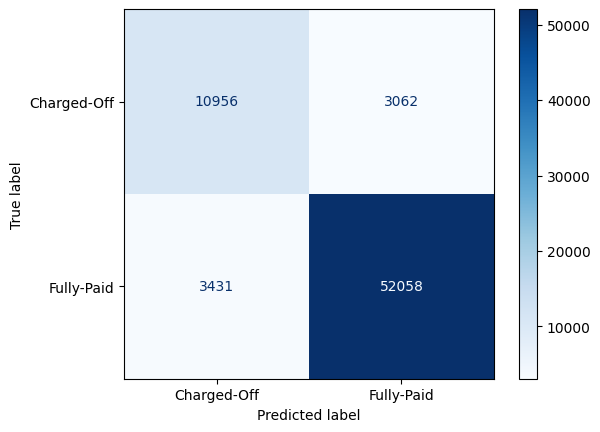

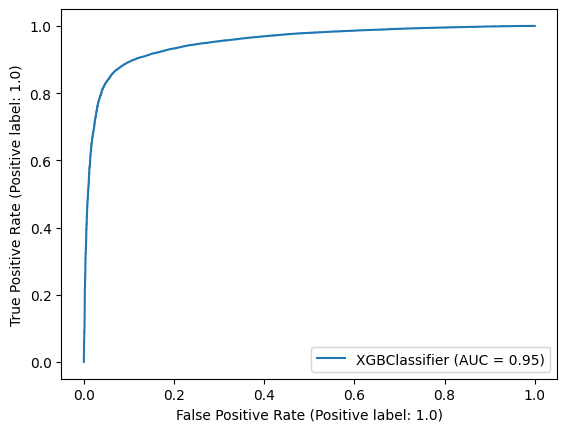

In [ ]:
disp = ConfusionMatrixDisplay.from_estimator(
    xgb_clf_tuned, X_test, y_test, 
    cmap='Blues', values_format='d', 
    display_labels=['Charged-Off', 'Fully-Paid']
)

disp = RocCurveDisplay.from_estimator(xgb_clf_tuned, X_test, y_test)

#3.10. Dự đoán trên dữ liệu mới

## 3.10.1. Dữ liệu năm 2016

In [ ]:
data16 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/R Python CK/lc_2016.csv')

keep_list = ['last_fico_range_high', 'dti', 'mo_sin_old_il_acct',
             'annual_inc', 'revol_util',
             'int_rate', 'total_acc', 'addr_state', 'bc_open_to_buy',
             'mths_since_recent_bc', 'revol_bal', 'bc_util', 'loan_amnt',
             'total_rev_hi_lim', 'fico_range_low', 'mo_sin_rcnt_rev_tl_op',
             'total_bal_ex_mort', 'earliest_cr_line', 'pct_tl_nvr_dlq',
             'avg_cur_bal', 'loan_status']

drop_list = [col for col in data16.columns if col not in keep_list]
data16.drop(labels=drop_list, axis=1, inplace=True)

data16['loan_status'] = data16.loan_status.map({'Fully Paid':1, 'Charged Off':0})

for (columnName, columnData) in data16.iteritems():
    if(columnData.dtype != 'float64'):
        if columnData.dtype == 'object':
            le = preprocessing.LabelEncoder()
            le.fit(columnData.values.astype(str))
            data16[columnName] = le.transform(columnData.values.astype(str))
        else:
            le = preprocessing.LabelEncoder()
            le.fit(columnData.values)
            data16[columnName] = le.transform(columnData.values)
            
#data16.dropna(inplace=True)

X_16, y_16 = data16.drop('loan_status', axis=1), data16.loan_status
X_16 = scaler.transform(X_16)
X_16 = np.array(X_16).astype(np.float32)
y_16 = np.array(y_16).astype(np.float32)

<ipython-input-131-7c8007b4c510>:1: DtypeWarning: Columns (20,60) have mixed types. Specify dtype option on import or set low_memory=False.
  data16 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/R Python CK/lc_2016.csv')


In [ ]:
#XGBoost
y_16_pred = xgb_clf.predict(X_16)
print_score(y_16, y_16_pred, train=False)

Test Result:
Accuracy Score: 91.54%
_______________________________________________
CLASSIFICATION REPORT:
               0.0       1.0  accuracy  macro avg  weighted avg
precision     0.86      0.93      0.92       0.89          0.91
recall        0.76      0.96      0.92       0.86          0.92
f1-score      0.81      0.95      0.92       0.88          0.91
support   68242.00 224853.00      0.92  293095.00     293095.00
_______________________________________________
Confusion Matrix: 
 [[ 52059  16183]
 [  8627 216226]]



In [ ]:
#XGBoost Tuned
y_16_pred = xgb_clf_tuned.predict(X_16)
print_score(y_16, y_16_pred, train=False)

Test Result:
Accuracy Score: 91.96%
_______________________________________________
CLASSIFICATION REPORT:
               0.0       1.0  accuracy  macro avg  weighted avg
precision     0.86      0.93      0.92       0.90          0.92
recall        0.78      0.96      0.92       0.87          0.92
f1-score      0.82      0.95      0.92       0.88          0.92
support   68242.00 224853.00      0.92  293095.00     293095.00
_______________________________________________
Confusion Matrix: 
 [[ 52966  15276]
 [  8294 216559]]



##3.10.2. Dữ liệu năm 2017

In [ ]:
data17 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/R Python CK/lc_2017.csv')

keep_list = ['last_fico_range_high', 'dti', 'mo_sin_old_il_acct',
             'annual_inc', 'revol_util',
             'int_rate', 'total_acc', 'addr_state', 'bc_open_to_buy',
             'mths_since_recent_bc', 'revol_bal', 'bc_util', 'loan_amnt',
             'total_rev_hi_lim', 'fico_range_low', 'mo_sin_rcnt_rev_tl_op',
             'total_bal_ex_mort', 'earliest_cr_line', 'pct_tl_nvr_dlq',
             'avg_cur_bal', 'loan_status']

drop_list = [col for col in data17.columns if col not in keep_list]
data17.drop(labels=drop_list, axis=1, inplace=True)

data17['loan_status'] = data17.loan_status.map({'Fully Paid':1, 'Charged Off':0})

for (columnName, columnData) in data17.iteritems():
    if(columnData.dtype != 'float64'):
        if columnData.dtype == 'object':
            le = preprocessing.LabelEncoder()
            le.fit(columnData.values.astype(str))
            data17[columnName] = le.transform(columnData.values.astype(str))
        else:
            le = preprocessing.LabelEncoder()
            le.fit(columnData.values)
            data17[columnName] = le.transform(columnData.values)

#data17.dropna(inplace=True)

X_17, y_17 = data17.drop('loan_status', axis=1), data17.loan_status
X_17 = scaler.transform(X_17)
X_17 = np.array(X_17).astype(np.float32)
y_17 = np.array(y_17).astype(np.float32)

In [ ]:
#XGBoost
y_17_pred = xgb_clf.predict(X_17)
print_score(y_17, y_17_pred, train=False)

Test Result:
Accuracy Score: 93.06%
_______________________________________________
CLASSIFICATION REPORT:
               0.0       1.0  accuracy  macro avg  weighted avg
precision     0.92      0.93      0.93       0.93          0.93
recall        0.77      0.98      0.93       0.87          0.93
f1-score      0.84      0.96      0.93       0.90          0.93
support   39148.00 130152.00      0.93  169300.00     169300.00
_______________________________________________
Confusion Matrix: 
 [[ 30100   9048]
 [  2708 127444]]



In [ ]:
#XGBoost Tuned
y_17_pred = xgb_clf_tuned.predict(X_17)
print_score(y_17, y_17_pred, train=False)

Test Result:
Accuracy Score: 93.57%
_______________________________________________
CLASSIFICATION REPORT:
               0.0       1.0  accuracy  macro avg  weighted avg
precision     0.93      0.94      0.94       0.93          0.94
recall        0.79      0.98      0.94       0.88          0.94
f1-score      0.85      0.96      0.94       0.90          0.93
support   39148.00 130152.00      0.94  169300.00     169300.00
_______________________________________________
Confusion Matrix: 
 [[ 30758   8390]
 [  2493 127659]]



##3.10.3. Dữ liệu năm 2018

In [ ]:
data18 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/R Python CK/lc_2018.csv')

keep_list = ['last_fico_range_high', 'dti', 'mo_sin_old_il_acct',
             'annual_inc', 'revol_util',
             'int_rate', 'total_acc', 'addr_state', 'bc_open_to_buy',
             'mths_since_recent_bc', 'revol_bal', 'bc_util', 'loan_amnt',
             'total_rev_hi_lim', 'fico_range_low', 'mo_sin_rcnt_rev_tl_op',
             'total_bal_ex_mort', 'earliest_cr_line', 'pct_tl_nvr_dlq',
             'avg_cur_bal', 'loan_status']

drop_list = [col for col in data18.columns if col not in keep_list]
data18.drop(labels=drop_list, axis=1, inplace=True)

data18['loan_status'] = data18.loan_status.map({'Fully Paid':1, 'Charged Off':0})

from sklearn import preprocessing
for (columnName, columnData) in data18.iteritems():
    if(columnData.dtype != 'float64'):
        if columnData.dtype == 'object':
            le = preprocessing.LabelEncoder()
            le.fit(columnData.values.astype(str))
            data18[columnName] = le.transform(columnData.values.astype(str))
        else:
            le = preprocessing.LabelEncoder()
            le.fit(columnData.values)
            data18[columnName] = le.transform(columnData.values)

#data18.dropna(inplace=True)

X_18, y_18 = data18.drop('loan_status', axis=1), data18.loan_status
X_18 = scaler.transform(X_18)
X_18 = np.array(X_18).astype(np.float32)
y_18 = np.array(y_18).astype(np.float32)

<ipython-input-135-396d576af03f>:1: DtypeWarning: Columns (130,131,132,135,136,137,140) have mixed types. Specify dtype option on import or set low_memory=False.
  data18 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/R Python CK/lc_2018.csv')


In [ ]:
#XGBoost
y_18_pred = xgb_clf.predict(X_18)
print_score(y_18, y_18_pred, train=False)

Test Result:
Accuracy Score: 95.06%
_______________________________________________
CLASSIFICATION REPORT:
              0.0      1.0  accuracy  macro avg  weighted avg
precision    0.94     0.95      0.95       0.95          0.95
recall       0.73     0.99      0.95       0.86          0.95
f1-score     0.82     0.97      0.95       0.90          0.95
support   8867.00 47444.00      0.95   56311.00      56311.00
_______________________________________________
Confusion Matrix: 
 [[ 6474  2393]
 [  386 47058]]



In [ ]:
#XGBoost
y_18_pred = xgb_clf_tuned.predict(X_18)
print_score(y_18, y_18_pred, train=False)

Test Result:
Accuracy Score: 95.37%
_______________________________________________
CLASSIFICATION REPORT:
              0.0      1.0  accuracy  macro avg  weighted avg
precision    0.95     0.95      0.95       0.95          0.95
recall       0.75     0.99      0.95       0.87          0.95
f1-score     0.84     0.97      0.95       0.90          0.95
support   8867.00 47444.00      0.95   56311.00      56311.00
_______________________________________________
Confusion Matrix: 
 [[ 6608  2259]
 [  351 47093]]

